In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import os

from data import processing_data
from settings import BASE_DIR

# Loading our dataset
data_path = os.path.join(BASE_DIR, "dataset", "train.csv")
df = pd.read_csv(data_path)
# df.head()

| Siêu tham số           | Ý nghĩa                                                                 | Giá trị phổ biến / Mặc định       | Ảnh hưởng đến mô hình                                                        |
|------------------------|------------------------------------------------------------------------|-----------------------------------|--------------------------------------------------------------------------------|
| `n_estimators`         | Số lượng cây trong rừng                                                | `[50, 100, 200, 300]` (mặc định: 100) | Tăng số lượng cây giúp mô hình ổn định hơn nhưng huấn luyện lâu hơn         |
| `max_depth`            | Độ sâu tối đa của cây                                                  | `[None, 5, 10, 15]`               | Giới hạn độ sâu tránh overfitting; `None` cho phép cây phát triển tối đa    |
| `min_samples_split`    | Số mẫu tối thiểu để chia một node                                      | `[2, 5, 10]`                      | Giá trị lớn làm cây bớt phức tạp, tránh chia nhỏ quá mức                     |
| `min_samples_leaf`     | Số mẫu tối thiểu tại một node lá                                       | `[1, 3, 5]`                       | Tăng giá trị giúp cây tổng quát hơn, giảm overfitting                        |
| `max_features`         | Số lượng đặc trưng được xét tại mỗi lần chia node                      | `['sqrt', 'log2', None]`         | Tăng tính ngẫu nhiên, giúp đa dạng hóa cây và giảm overfitting               |
| `bootstrap`            | Có sử dụng lấy mẫu có hoàn lại không                                   | `[True, False]`                  | `True` giúp đa dạng hóa cây (giảm overfitting), `False` dùng toàn bộ dữ liệu |
| `criterion`            | Hàm mất mát để đánh giá chất lượng node                               | `['squared_error', 'absolute_error']` | `squared_error` nhạy với outlier; `absolute_error` bền vững hơn với outlier  |
| `max_leaf_nodes`       | Số lượng node lá tối đa (giới hạn cấu trúc cây)                        | `None` hoặc số nguyên dương       | Giới hạn này giúp kiểm soát độ phức tạp mô hình                              |
| `n_jobs`               | Số luồng CPU sử dụng để train song song                                | `-1` (tất cả CPU)                | Tăng tốc độ huấn luyện mô hình                                               |
| `random_state`         | Hạt giống ngẫu nhiên cho reproducibility                               | `42`, hoặc số bất kỳ             | Giúp kết quả có thể lặp lại khi huấn luyện nhiều lần                         |


#### Lưu mô hình


 Fold 1
✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_1\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


TypeError: visualize_results() got an unexpected keyword argument 'model'

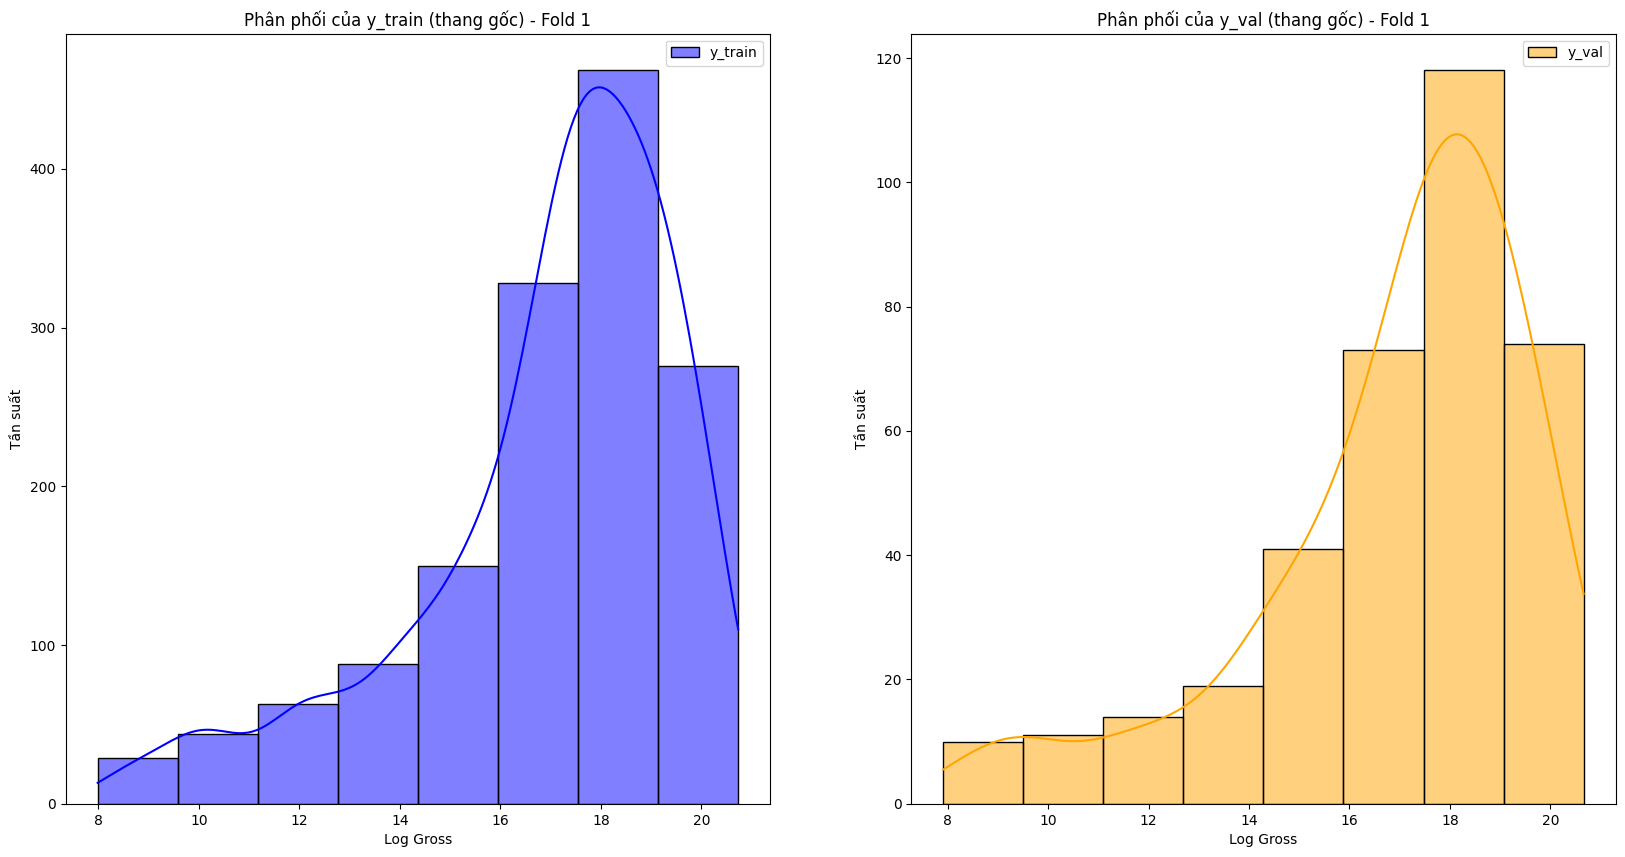

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from save import save_model
# from settings import BASE_DIR


param_grid = {
    'n_estimators': [200,300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],                    # Tăng lên để tránh overfitting ở lá rất nhỏ
    'max_features': ['sqrt', 'log2'],             # Số lượng feature được chọn ngẫu nhiên khi split
    'bootstrap': [True, False]                         # False đôi khi giúp giảm bias nhưng tăng variance
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    features = ['log_no_of_votes', 'log_budget',
                'log_genre_stat_feature','log_country_stat_feature','rating']

    target = 'log_gross'


    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest")

    base_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    
    
    save_model(model=best_model, model_name="random_forest",fold=fold+1,directory="best_models")
    
    print(" Best hyperparameters:", grid_search.best_params_)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def train_best_rf_model(X_train, y_train, cv=5, scoring='neg_mean_absolute_error'):
    """
    Huấn luyện mô hình RandomForestRegressor tốt nhất với GridSearchCV.

    Parameters:
        X_train (ndarray): Dữ liệu huấn luyện đầu vào.
        y_train (ndarray): Nhãn huấn luyện.
        cv (int): Số lượng folds dùng trong cross-validation.
        scoring (str): Chiến lược đánh giá. Mặc định là MAE âm.

    Returns:
        best_model (RandomForestRegressor): Mô hình tốt nhất.
        best_params (dict): Bộ tham số tốt nhất.
    """

    param_grid = {
        'n_estimators': [200, 300],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(
        rf, param_grid, cv=cv,
        scoring=scoring, n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"✅ Best parameters found: {grid_search.best_params_}")

    return grid_search.best_estimator_, grid_search.best_params_



📂 Fold 1


✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_1\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best parameters found: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
🔍 Best params for fold 1: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Overall Metrics (Train):
  R2: 0.7986
  MAE: 41255000.2823
  MAPE: 194.55%
Overall Metrics (Validation):
  R2: 0.6796
  MAE: 56531806.7626
  MAPE: 2762.44%


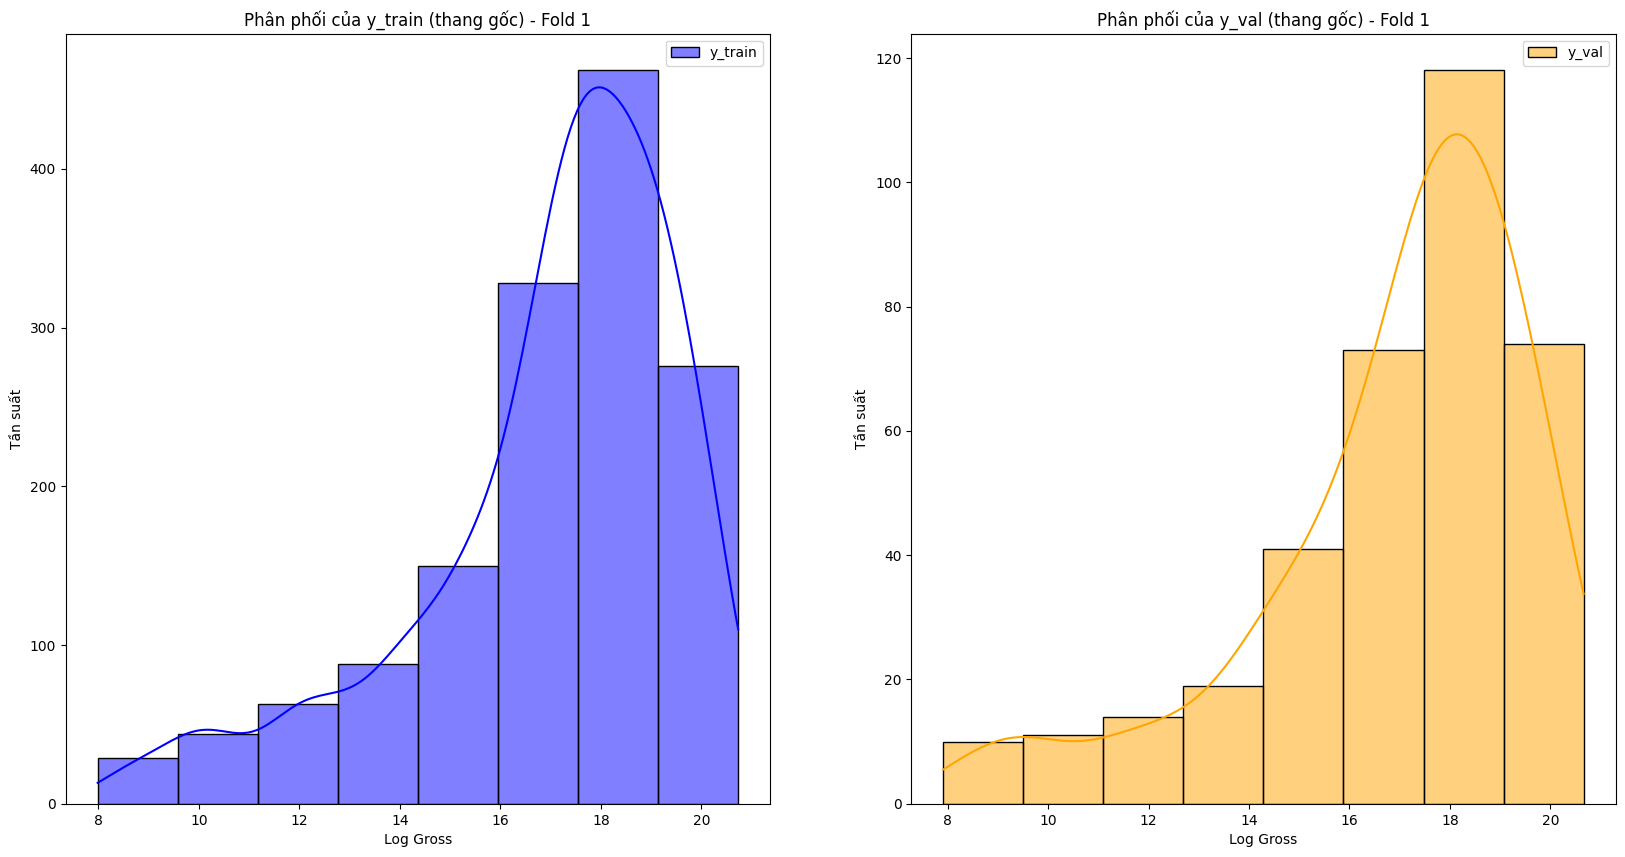

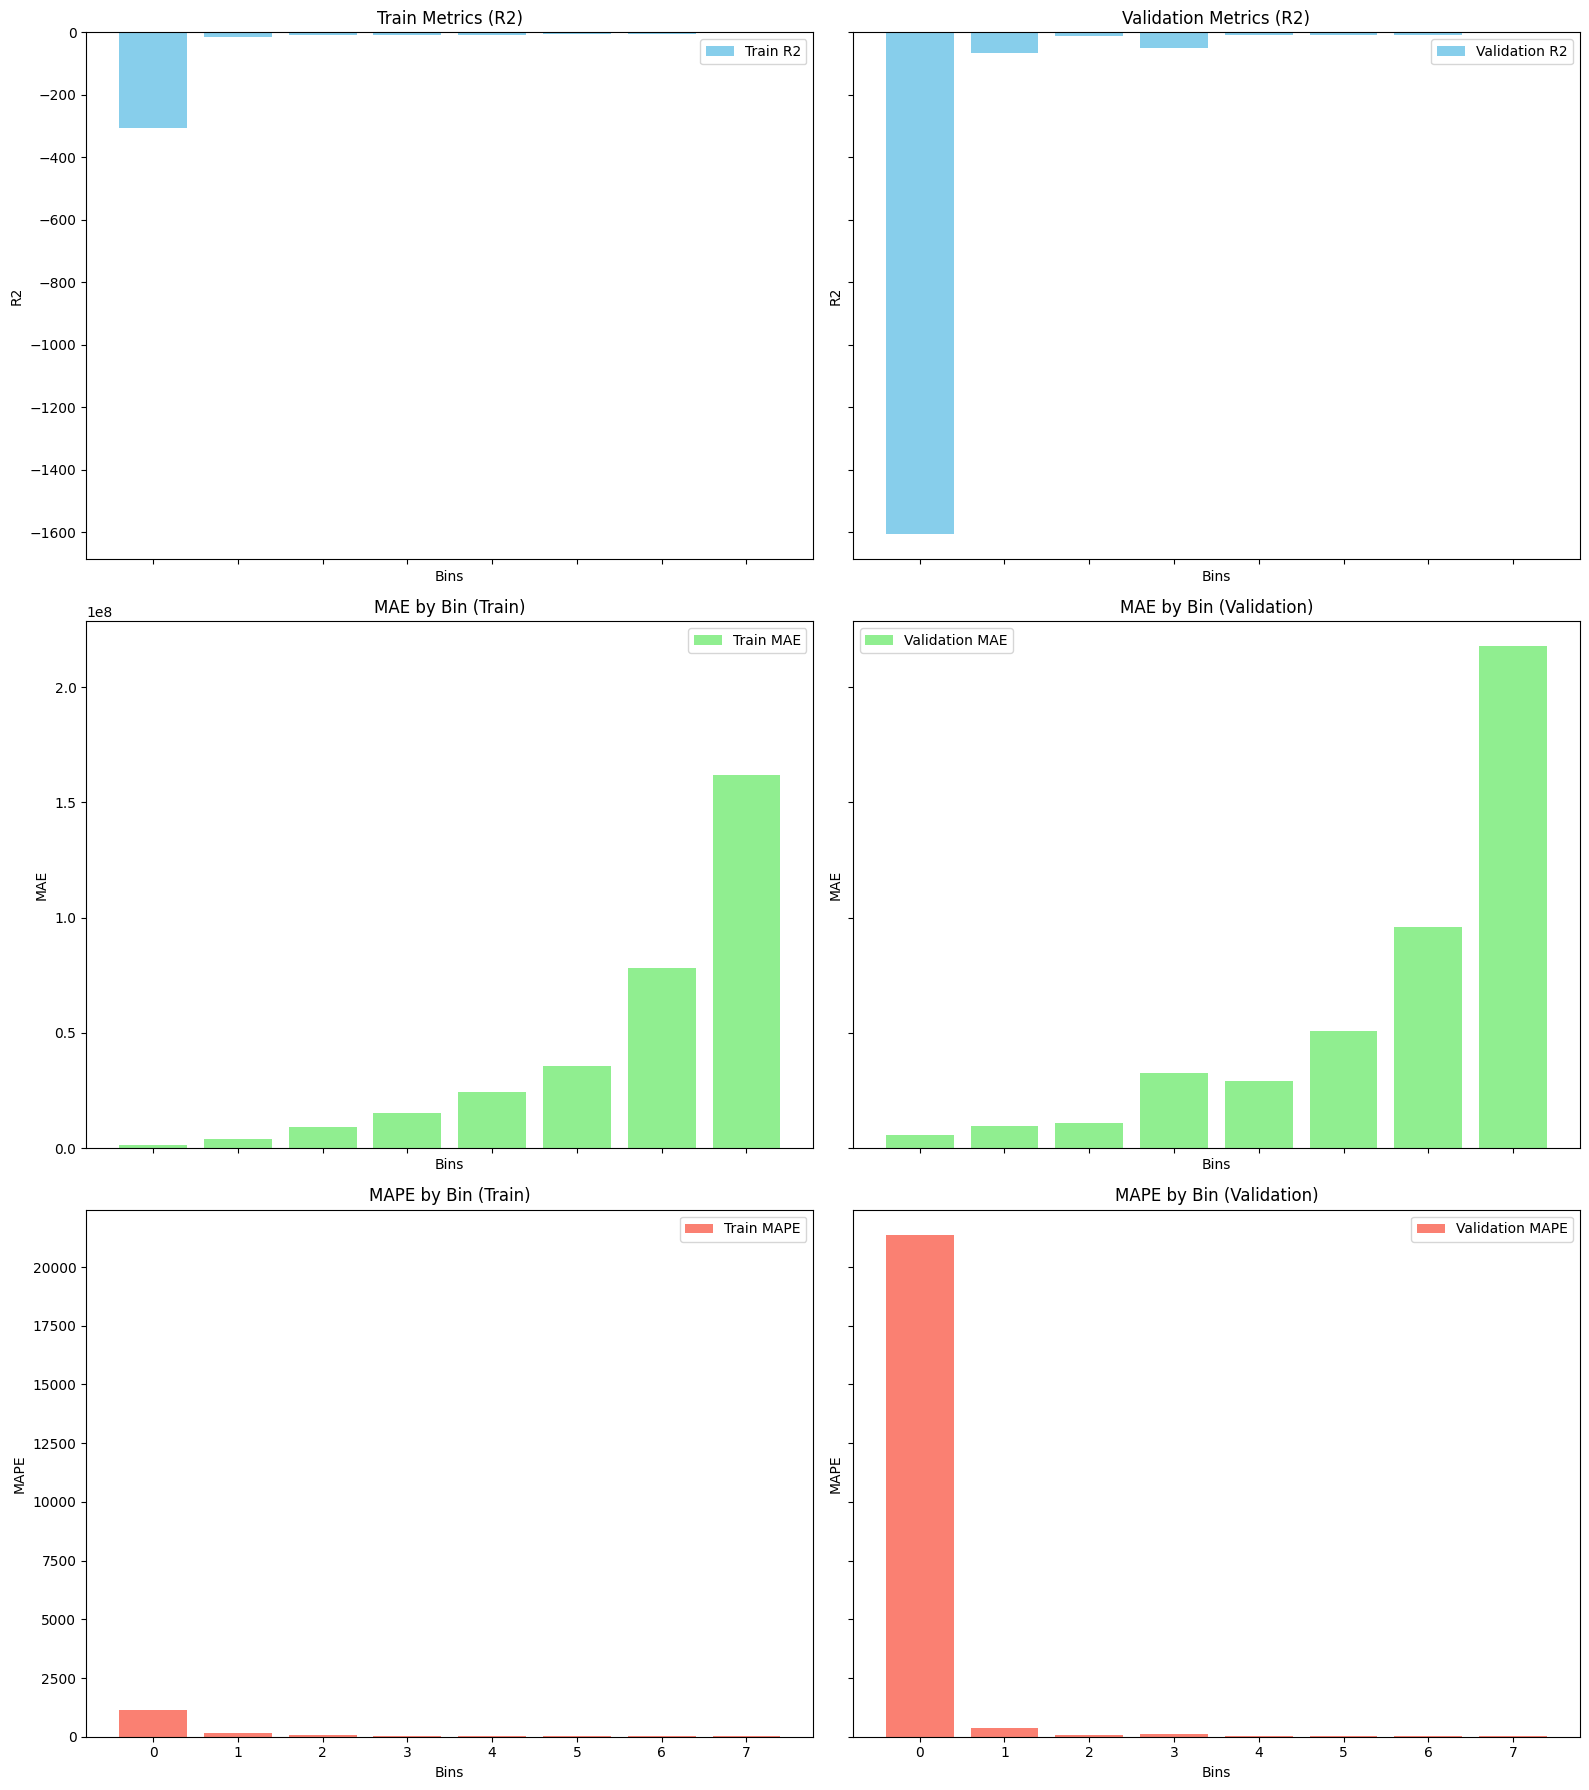


📂 Fold 2
✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_2\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
🔍 Best params for fold 2: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Overall Metrics (Train):
  R2: 0.7729
  MAE: 44935919.1889
  MAPE: 286.73%
Overall Metrics (Validation):
  R2: 0.6345
  MAE: 62230214.7558
  MAPE: 593.90%


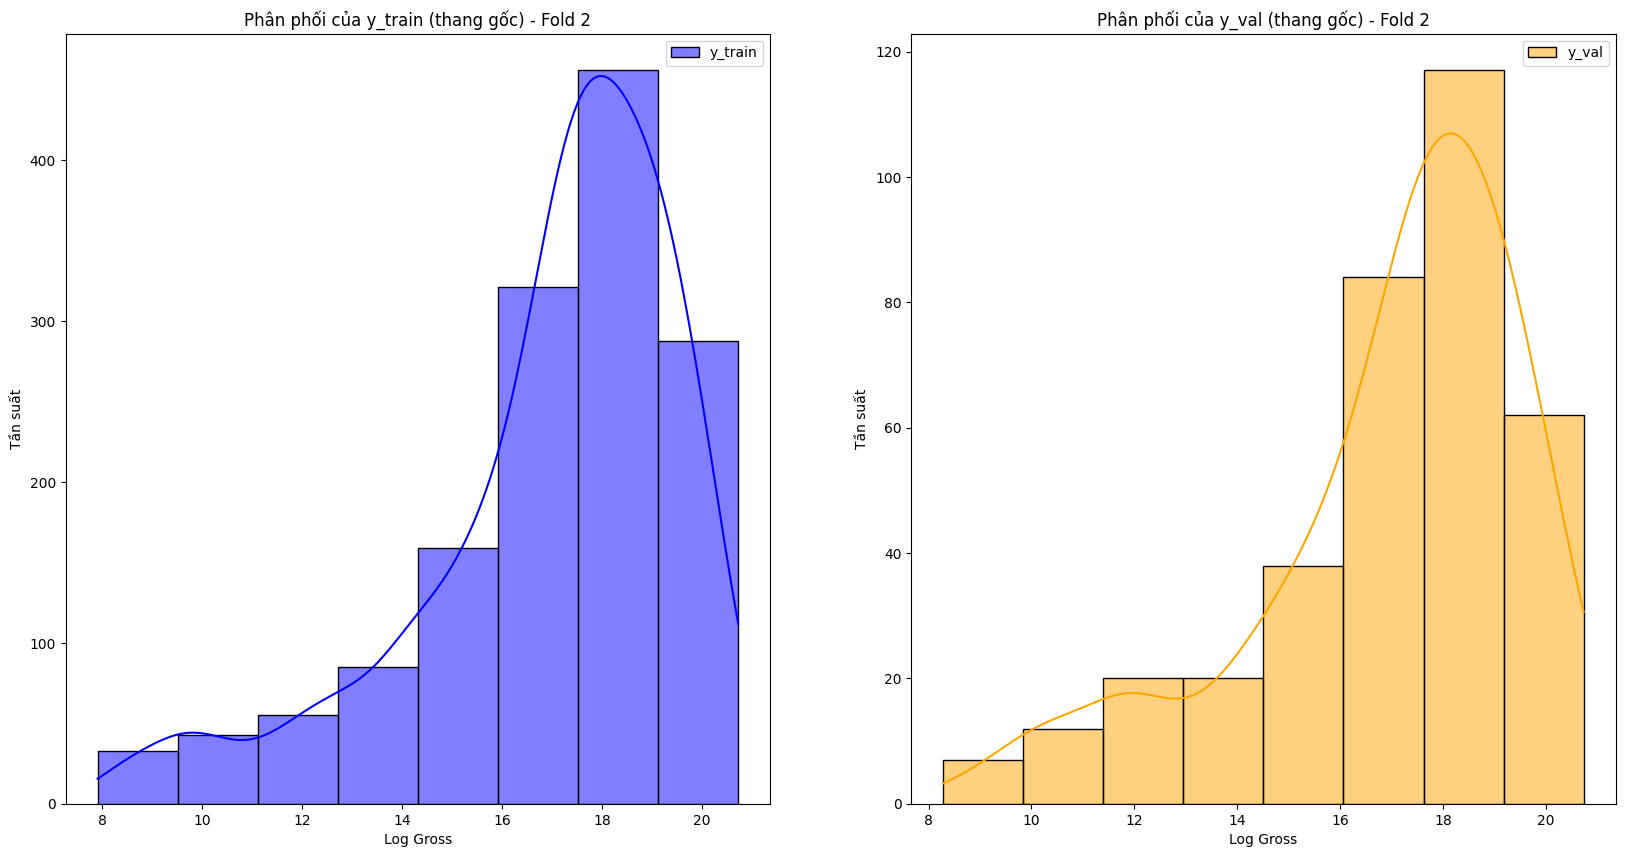

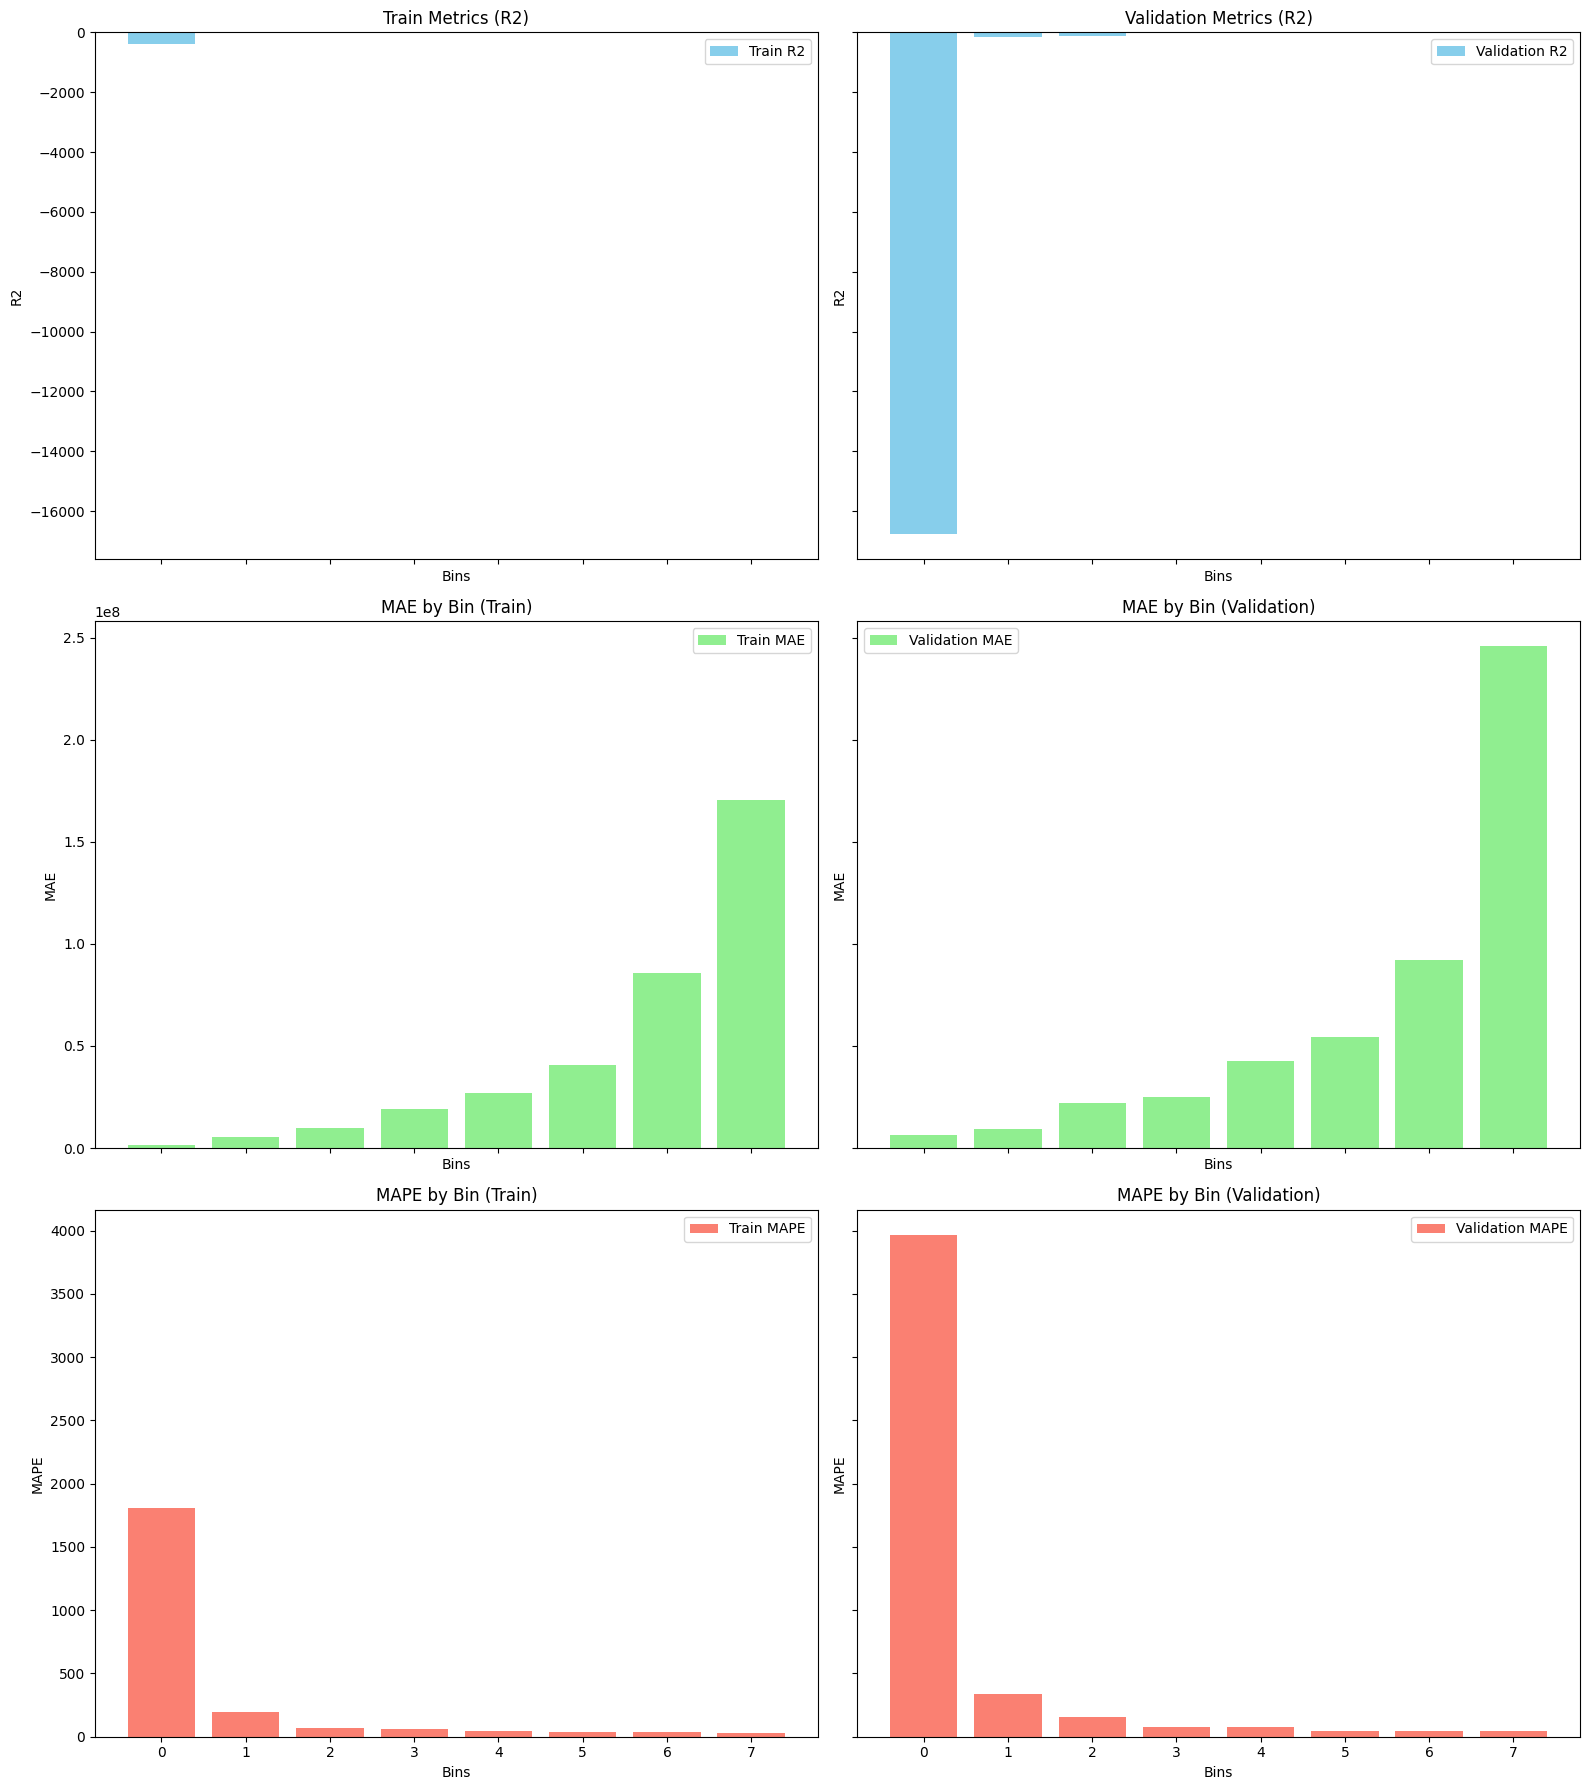


📂 Fold 3
✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_3\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best parameters found: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
🔍 Best params for fold 3: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Overall Metrics (Train):
  R2: 0.7979
  MAE: 40844705.0477
  MAPE: 225.18%
Overall Metrics (Validation):
  R2: 0.6347
  MAE: 60437078.5694
  MAPE: 703.49%


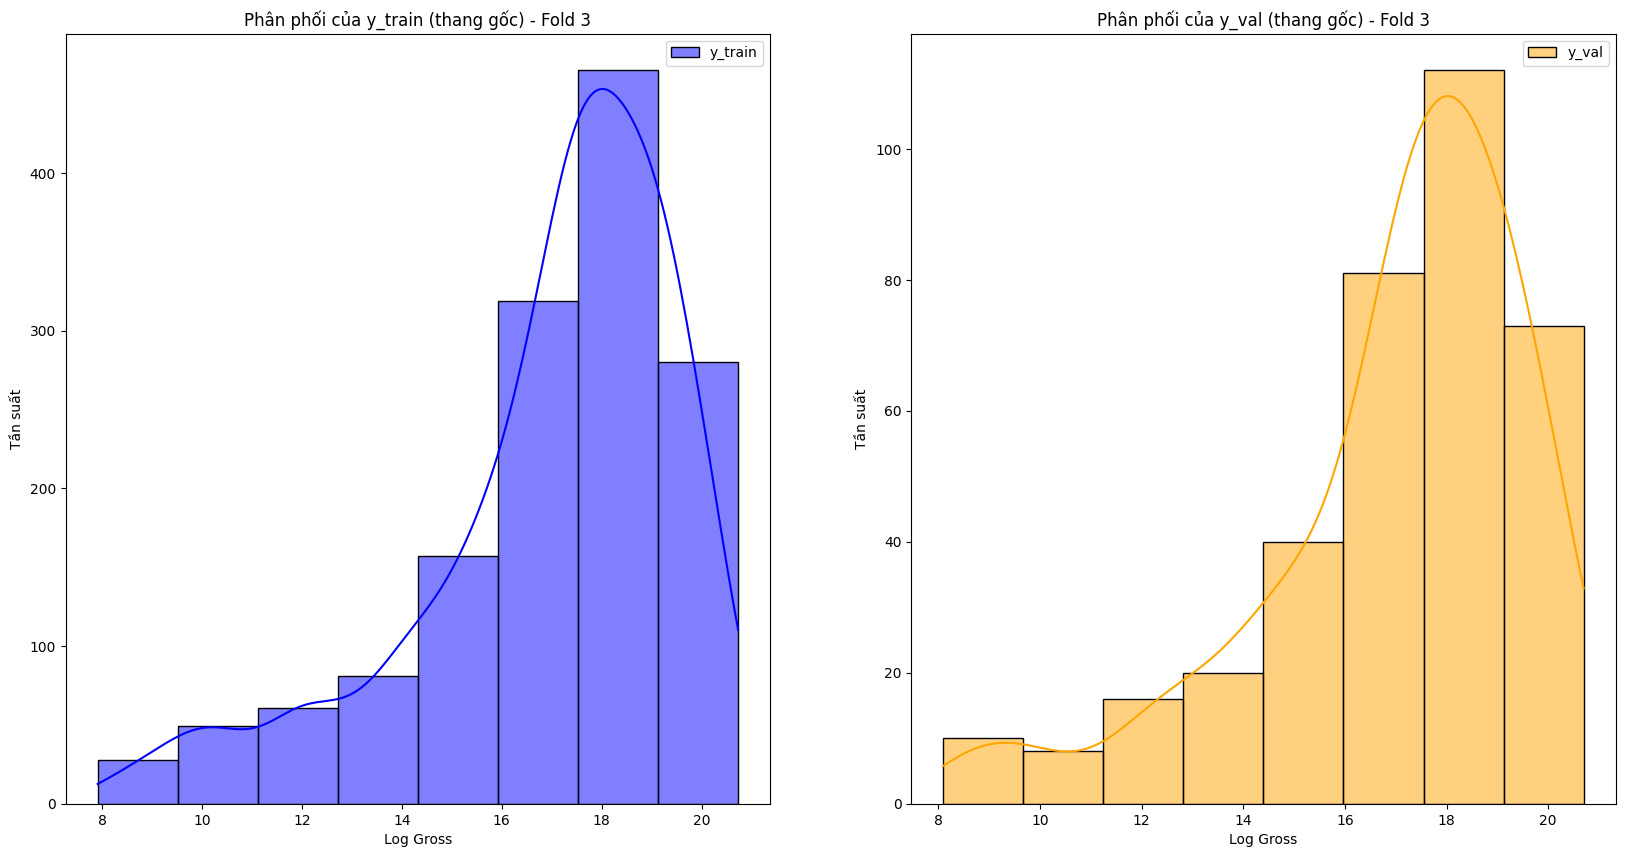

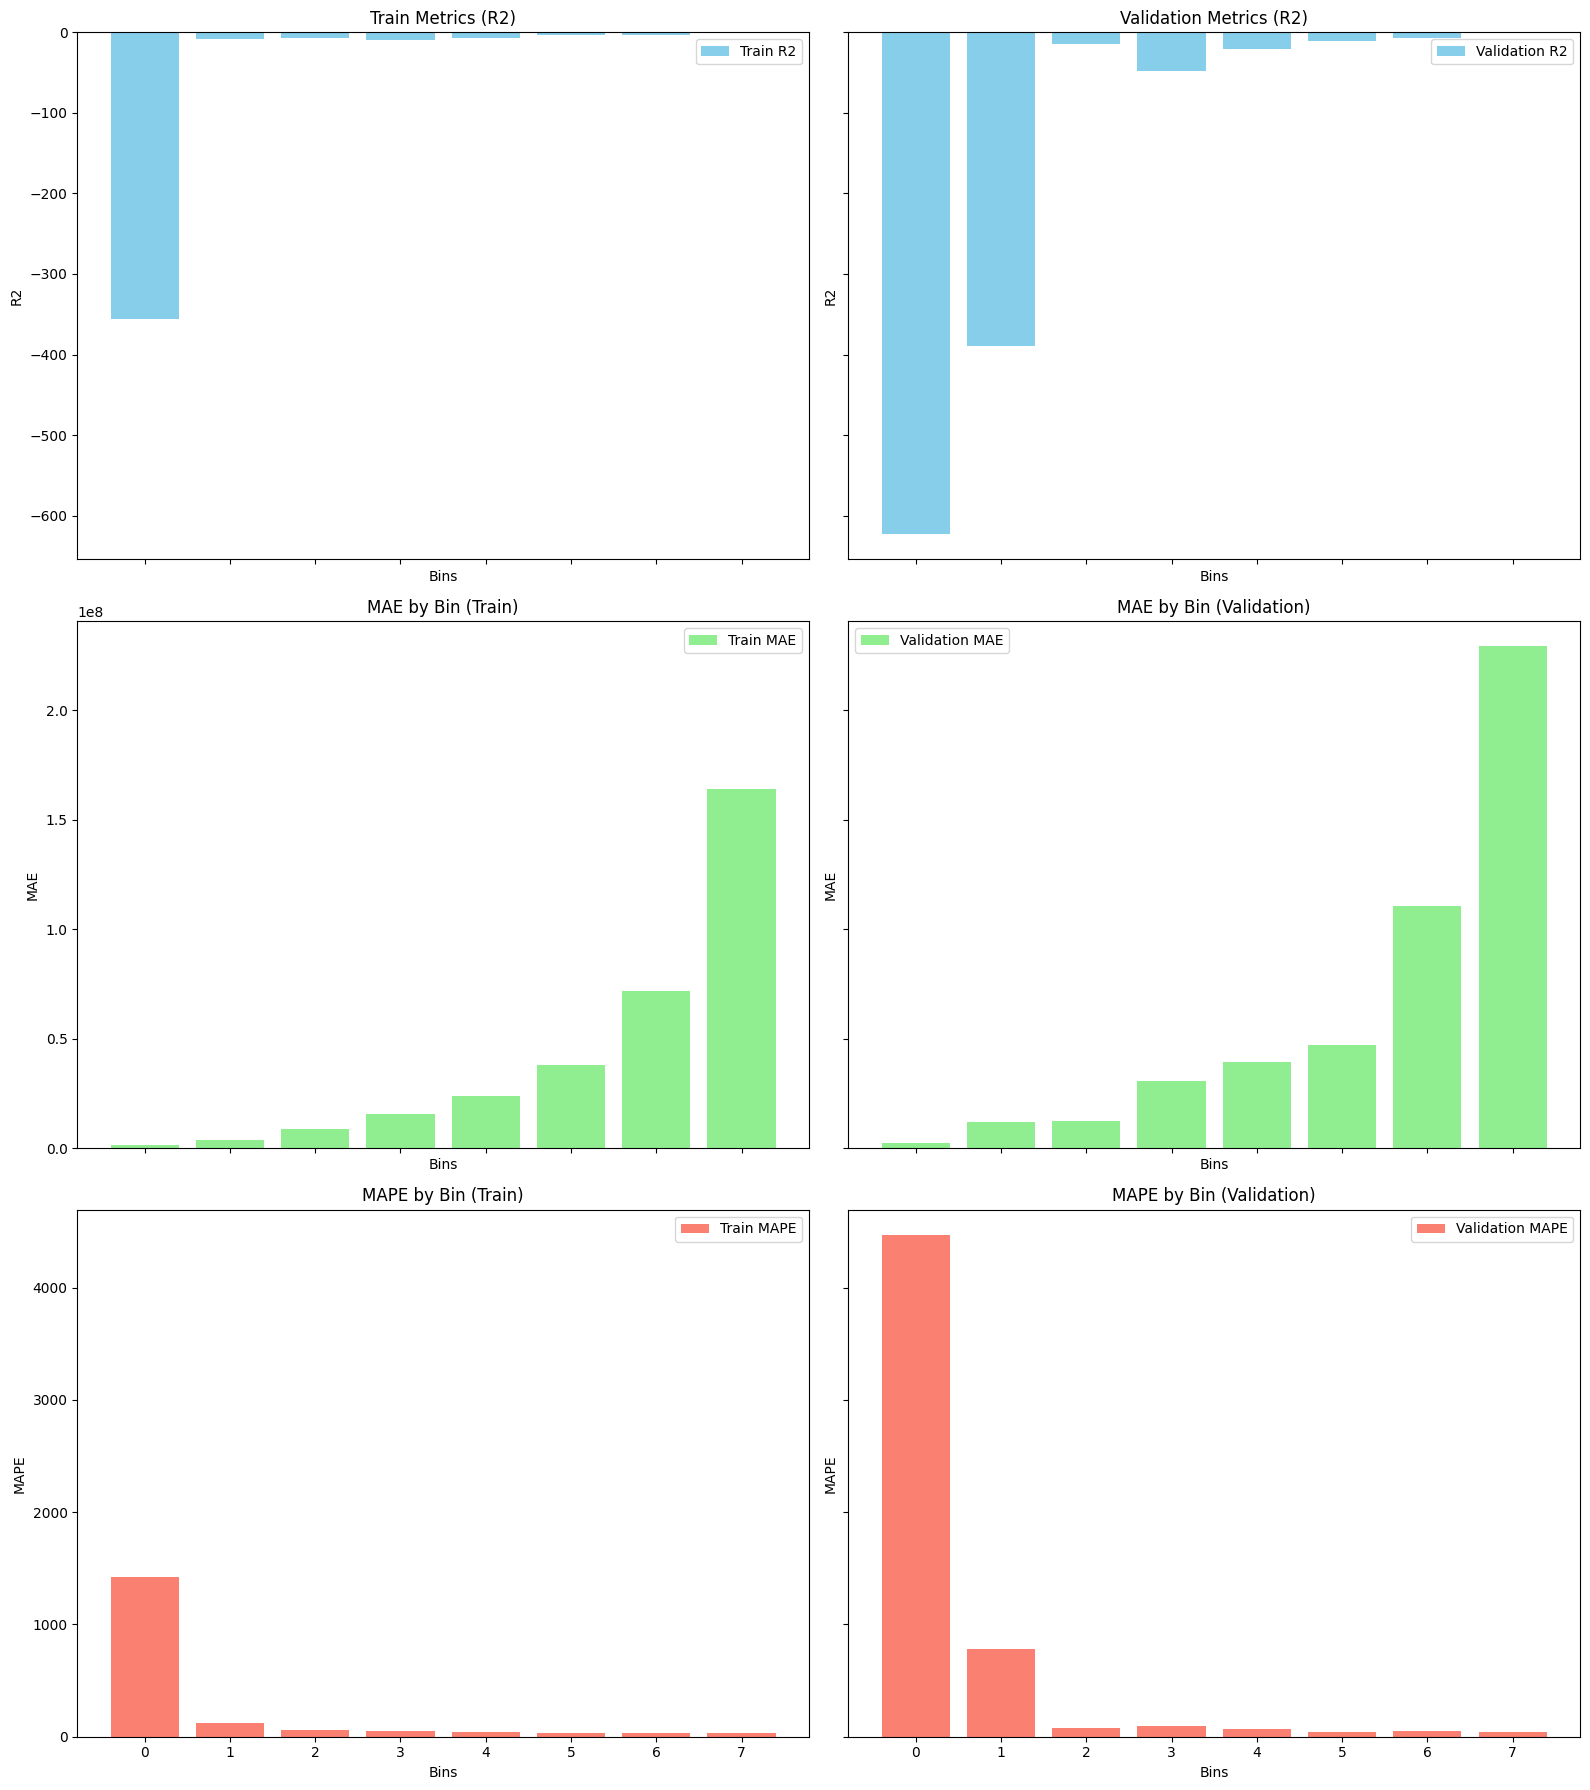


📂 Fold 4
✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_4\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
🔍 Best params for fold 4: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Overall Metrics (Train):
  R2: 0.7713
  MAE: 45493428.5539
  MAPE: 284.66%
Overall Metrics (Validation):
  R2: 0.5986
  MAE: 60219453.1312
  MAPE: 1251.56%


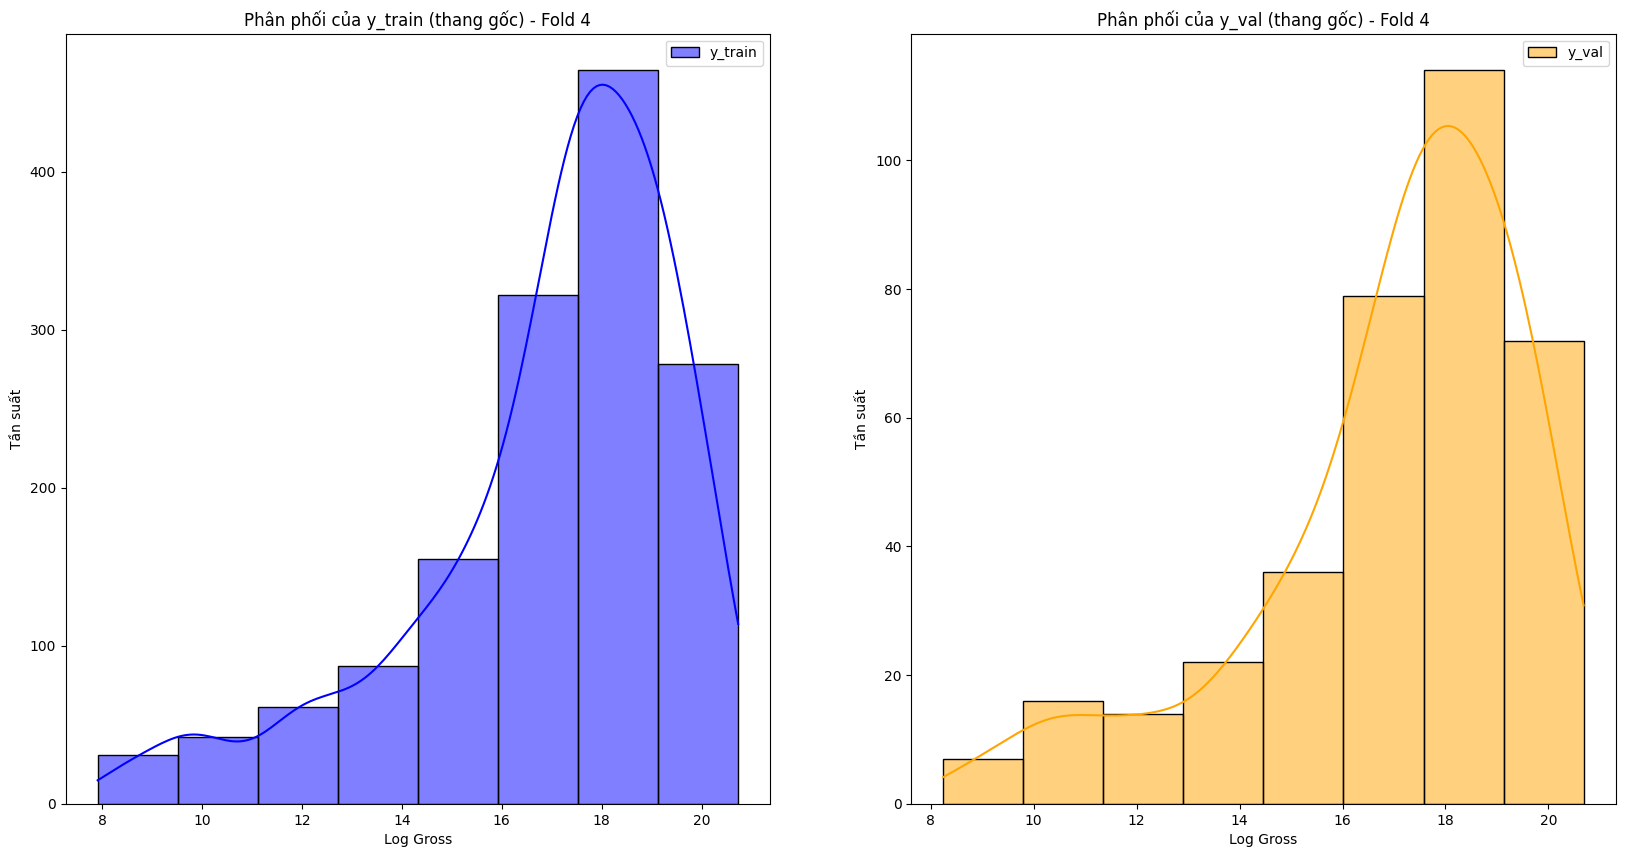

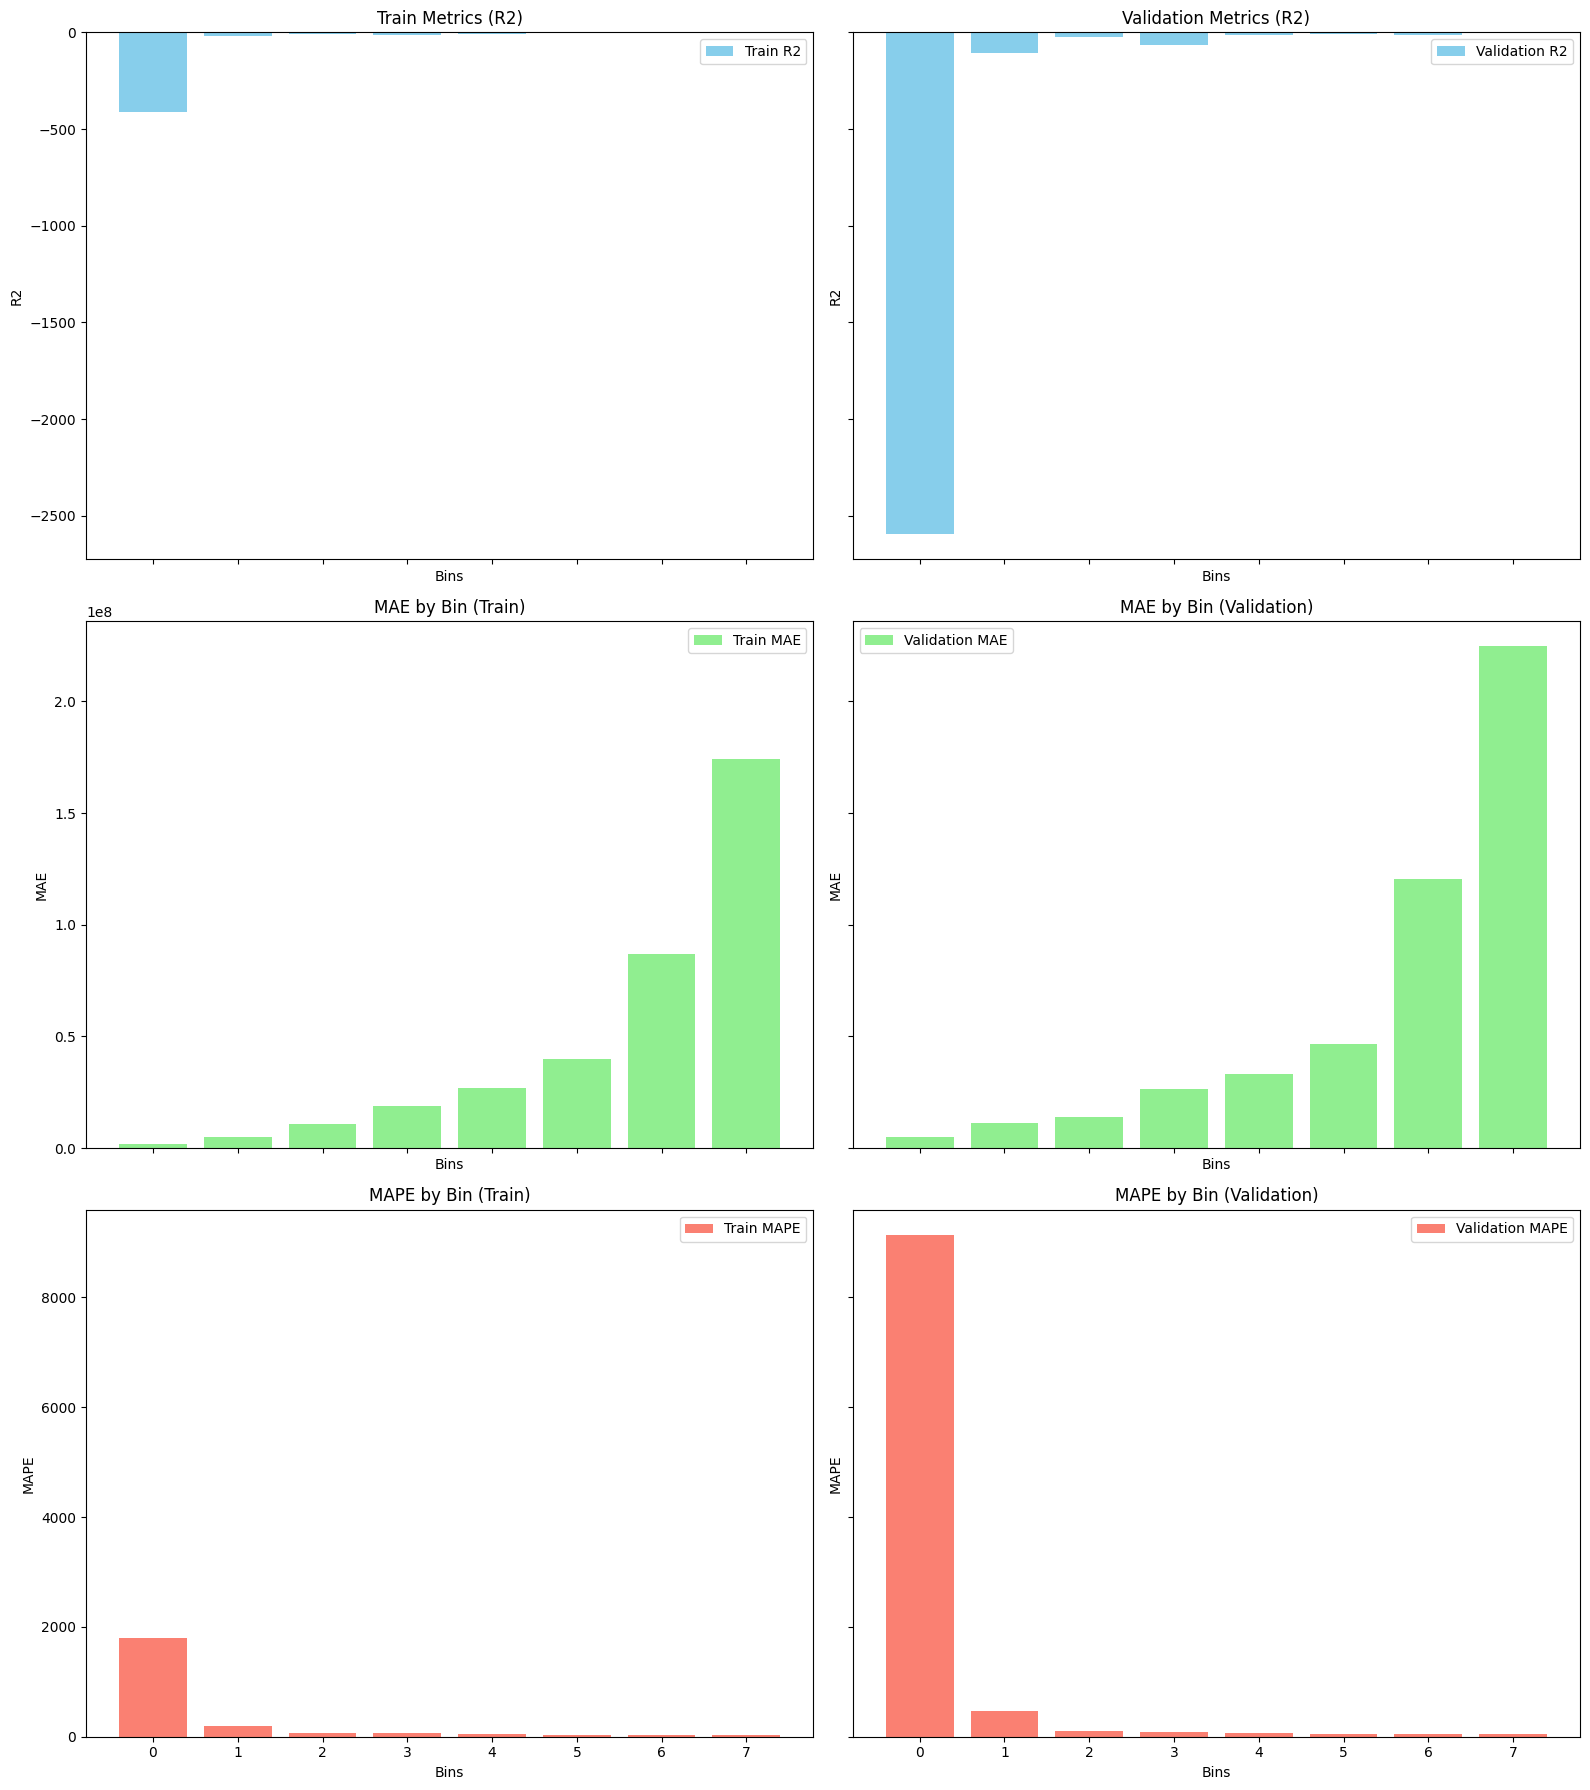


📂 Fold 5
✅ Scaler saved to: c:\Users\pc\dut\hk6\khdl\midterm\movie-analyst\best_models\random_forest\fold_5\scaler.pkl
Fitting 3 folds for each of 96 candidates, totalling 288 fits
✅ Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
🔍 Best params for fold 5: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Overall Metrics (Train):
  R2: 0.8363
  MAE: 39568380.6437
  MAPE: 136.12%
Overall Metrics (Validation):
  R2: 0.5306
  MAE: 63562533.2945
  MAPE: 954.81%


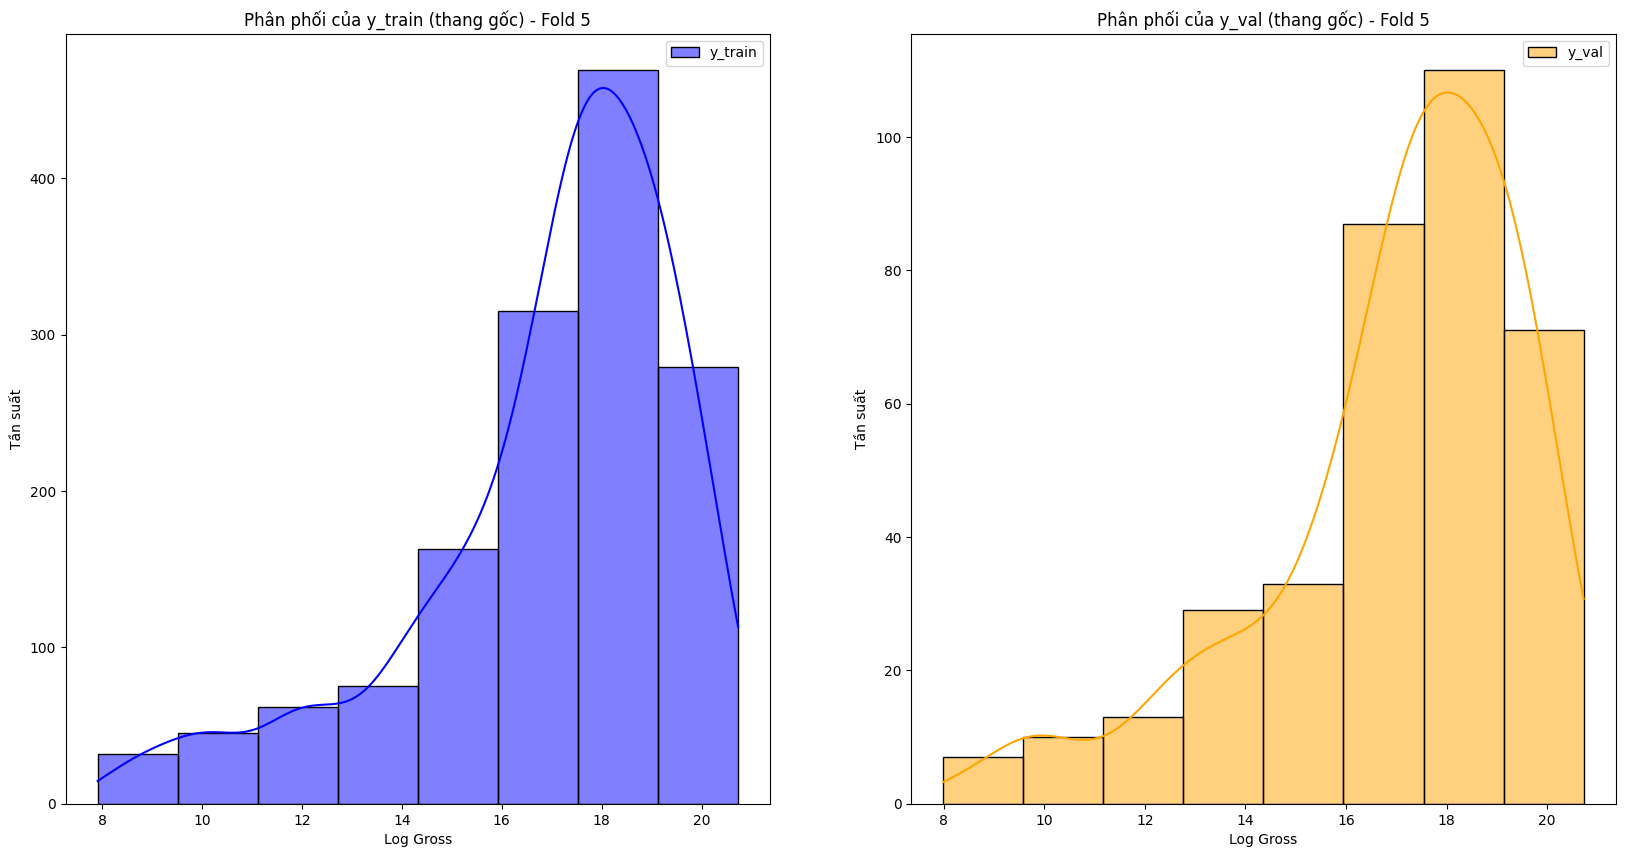

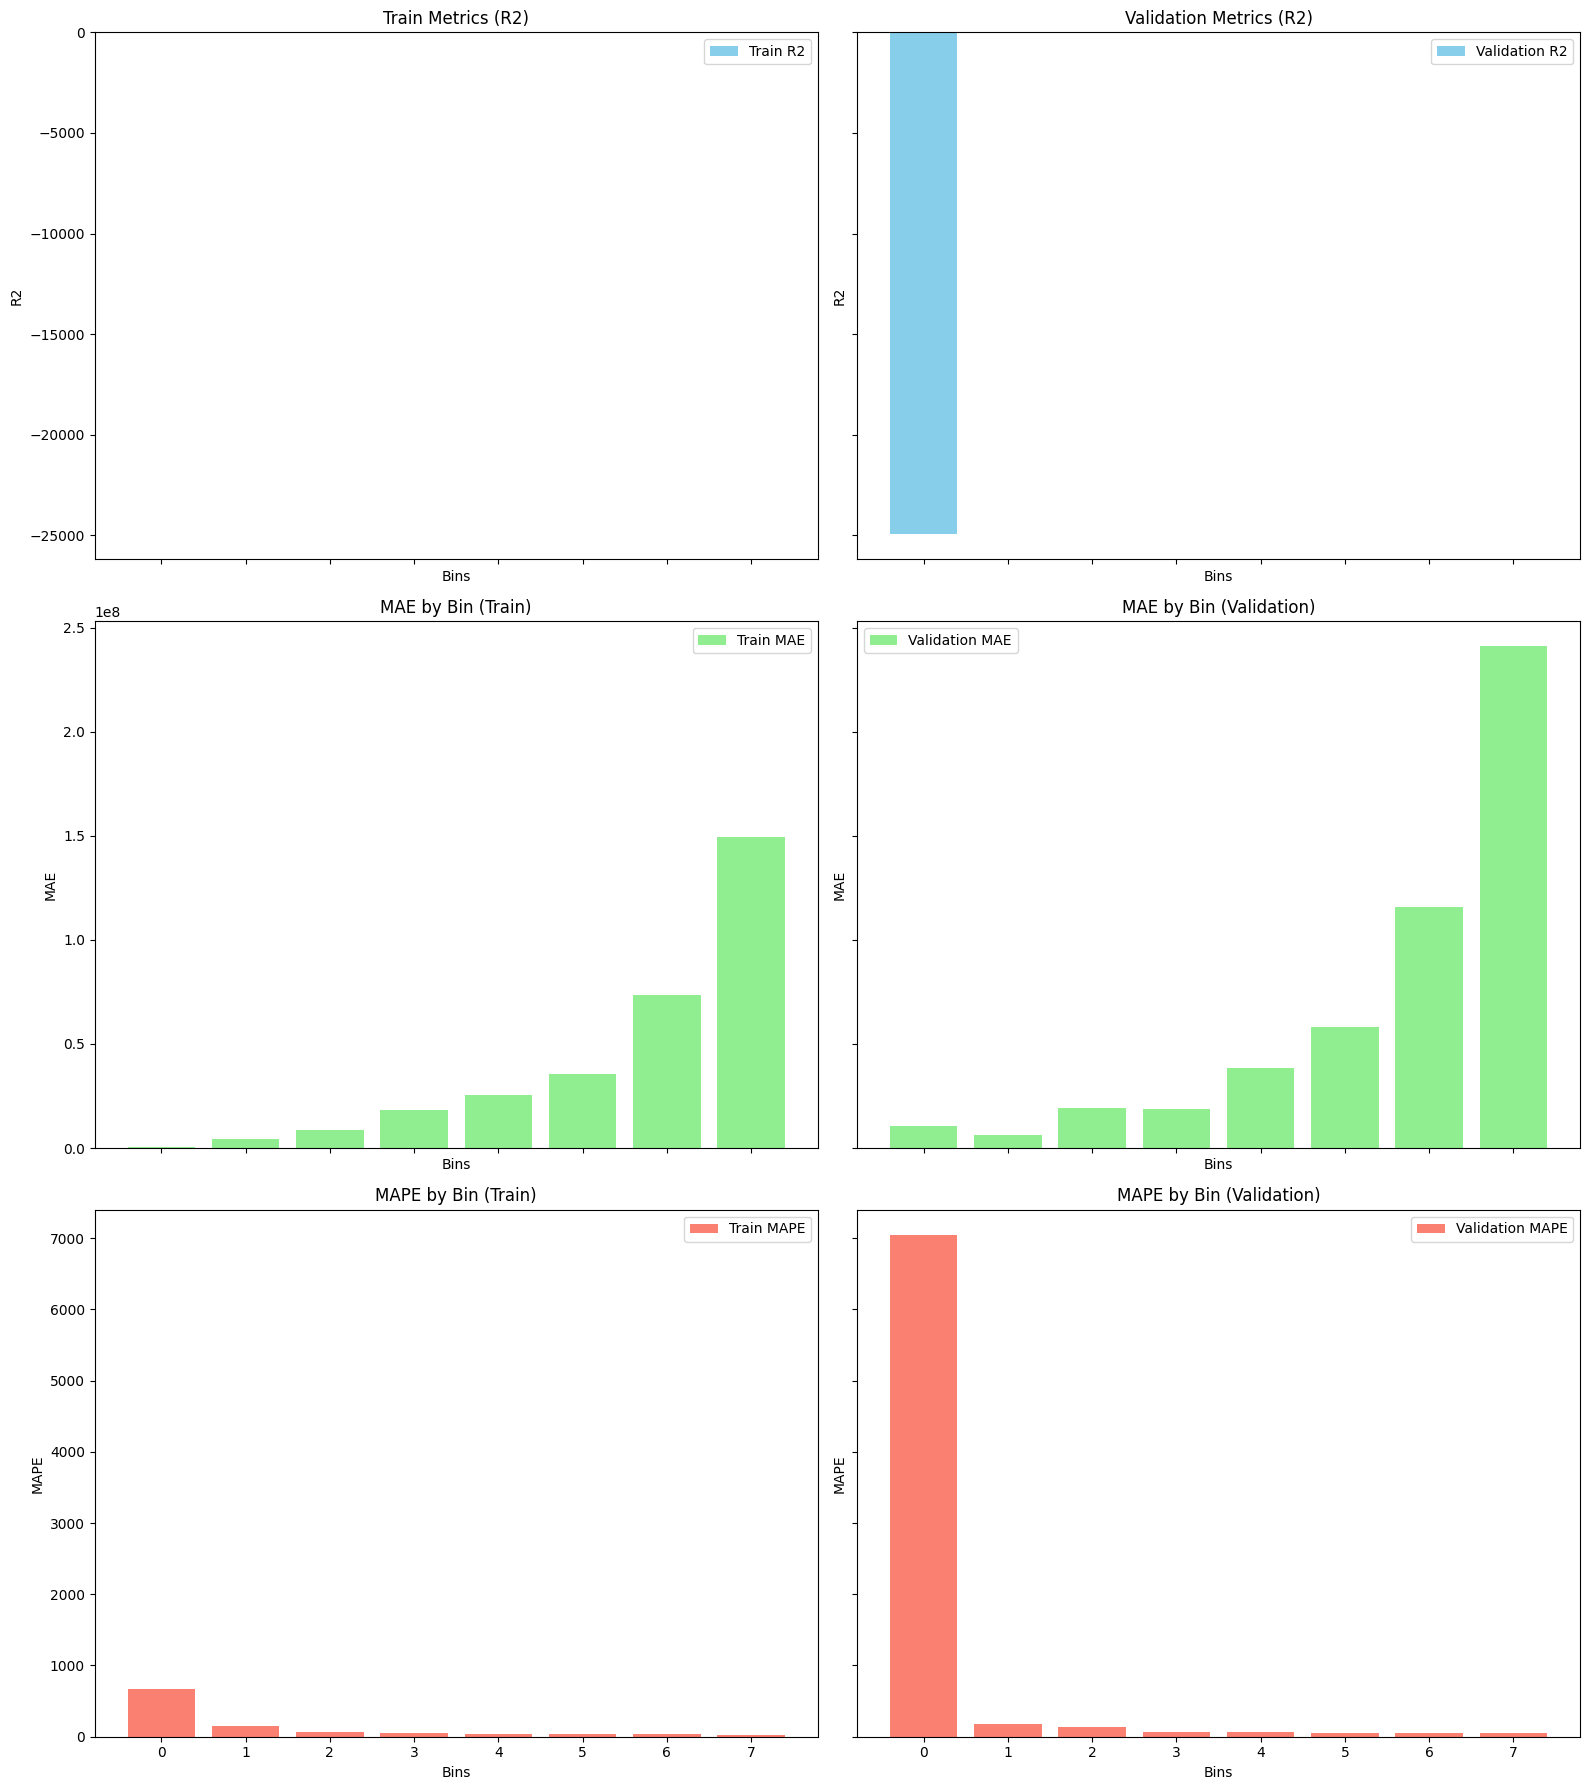

In [8]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import joblib
import os

# Các list lưu kết quả
train_r2_list, train_mae_list, train_mape_list = [], [], []
val_r2_list, val_mae_list, val_mape_list = [], [], []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n📂 Fold {fold + 1}")
    
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()
    
    X_train, y_train, X_val, y_val = processing_data(
        df_train, df_val,
        fold=fold,
        features=FEATURES,
        target=TARGET,
        model_name="random_forest",
    )

    best_model, best_params = train_best_rf_model(X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

    print(f"🔍 Best params for fold {fold + 1}: {best_params}")

    best_model.fit(X_train, y_train)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex=True, sharey='row')

    # Visualization
    df_train_result, train_r2, train_mae, train_mape = visualize_results(
        df_train, y_true=y_train, y_pred=train_preds,
        calculate_real_target=True, dataset_label="Train", axes=axes[:, 0]
    )

    df_val_result, val_r2, val_mae, val_mape = visualize_results(
        df_val, y_true=y_val, y_pred=val_preds,
        calculate_real_target=True, dataset_label="Validation", axes=axes[:, 1]
    )

    axes[0, 0].set_title("Train Metrics (R2)")
    axes[0, 1].set_title("Validation Metrics (R2)")

    plt.tight_layout()
    plt.show()

    # Lưu kết quả
    train_r2_list.append(train_r2)
    train_mae_list.append(train_mae)
    train_mape_list.append(train_mape * 100)

    val_r2_list.append(val_r2)
    val_mae_list.append(val_mae)
    val_mape_list.append(val_mape * 100)


In [15]:
import numpy as np
import pandas as pd

summary_df = pd.DataFrame({
    "Train R²": [f"{x:.2f}" for x in train_r2_list],
    "Val R²": [f"{x:.2f}" for x in val_r2_list],
    "Train MAE": [f"{x:.2f}" for x in train_mae_list],
    "Val MAE": [f"{x:.2f}" for x in val_mae_list],
    "Train MAPE (%)": [f"{x:.2f}" for x in train_mape_list],
    "Val MAPE (%)": [f"{x:.2f}" for x in val_mape_list],
})


print("\n📊 Bảng tổng hợp chỉ số theo từng fold:")
print(summary_df)

print("\n📊 Trung bình kết quả qua các folds:")
print(f"Train MAE: {np.mean(train_mae_list):.4f}")
print(f"Val  MAE: {np.mean(val_mae_list):.4f}")
print(f"Train R²  : {np.mean(train_r2_list):.4f}")
print(f"Val  R²  : {np.mean(val_r2_list):.4f}")
print(f"Train MAPE: {np.mean(train_mape_list):.2f}%")
print(f"Val  MAPE: {np.mean(val_mape_list):.2f}%")



📊 Bảng tổng hợp chỉ số theo từng fold:
  Train R² Val R²    Train MAE      Val MAE Train MAPE (%) Val MAPE (%)
0     0.80   0.68  41255000.28  56531806.76         194.55      2762.44
1     0.77   0.63  44935919.19  62230214.76         286.73       593.90
2     0.80   0.63  40844705.05  60437078.57         225.18       703.49
3     0.77   0.60  45493428.55  60219453.13         284.66      1251.56
4     0.84   0.53  39568380.64  63562533.29         136.12       954.81

📊 Trung bình kết quả qua các folds:
Train MAE: 42419486.7433
Val  MAE: 60596217.3027
Train R²  : 0.7954
Val  R²  : 0.6156
Train MAPE: 225.45%
Val  MAPE: 1253.24%


In [10]:
# In trung bình các chỉ số
print(train_mae_list)
print(val_mae_list)
print(train_r2_list)
print(val_r2_list)
print(train_mape_list)
print(val_mape_list)

print("\n📊 Trung bình kết quả qua các folds:")
print(f"Train MAE: {np.mean(train_mae_list):.4f}")
print(f"Val  MAE: {np.mean(val_mae_list):.4f}")
print(f"Train R²  : {np.mean(train_r2_list):.4f}")
print(f"Val  R²  : {np.mean(val_r2_list):.4f}")
print(f"Train MAPE: {np.mean(train_mape_list):.2f}%")
print(f"Val  MAPE: {np.mean(val_mape_list):.2f}%")

[41255000.28228483, 44935919.18891466, 40844705.04766747, 45493428.55388744, 39568380.64373736]
[56531806.76263357, 62230214.755823284, 60437078.5694312, 60219453.131210834, 63562533.29452]
[0.7986035128891629, 0.7728760903988976, 0.797884158141703, 0.7712729020626753, 0.8362810498812427]
[0.6795974858986551, 0.6345196376686713, 0.6346688535891793, 0.5986349907856279, 0.5305752079910886]
[194.55221728685345, 286.72568402183475, 225.180360872701, 284.6561862674168, 136.12105596871854]
[2762.4441176021123, 593.9004803796284, 703.493972801352, 1251.561867767776, 954.8108887634087]

📊 Trung bình kết quả qua các folds:
Train MAE: 42419486.7433
Val  MAE: 60596217.3027
Train R²  : 0.7954
Val  R²  : 0.6156
Train MAPE: 225.45%
Val  MAPE: 1253.24%


#### Thư viện Optuna


Fold 1
 Best hyperparameters: {'n_estimators': 219, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.490172278626588
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8489
MAE: 34,068,352.0442
MAPE: 1.22%
Test Metrics
R2 score: 0.6017
MAE: 62,668,626.7987
MAPE: 10.25%


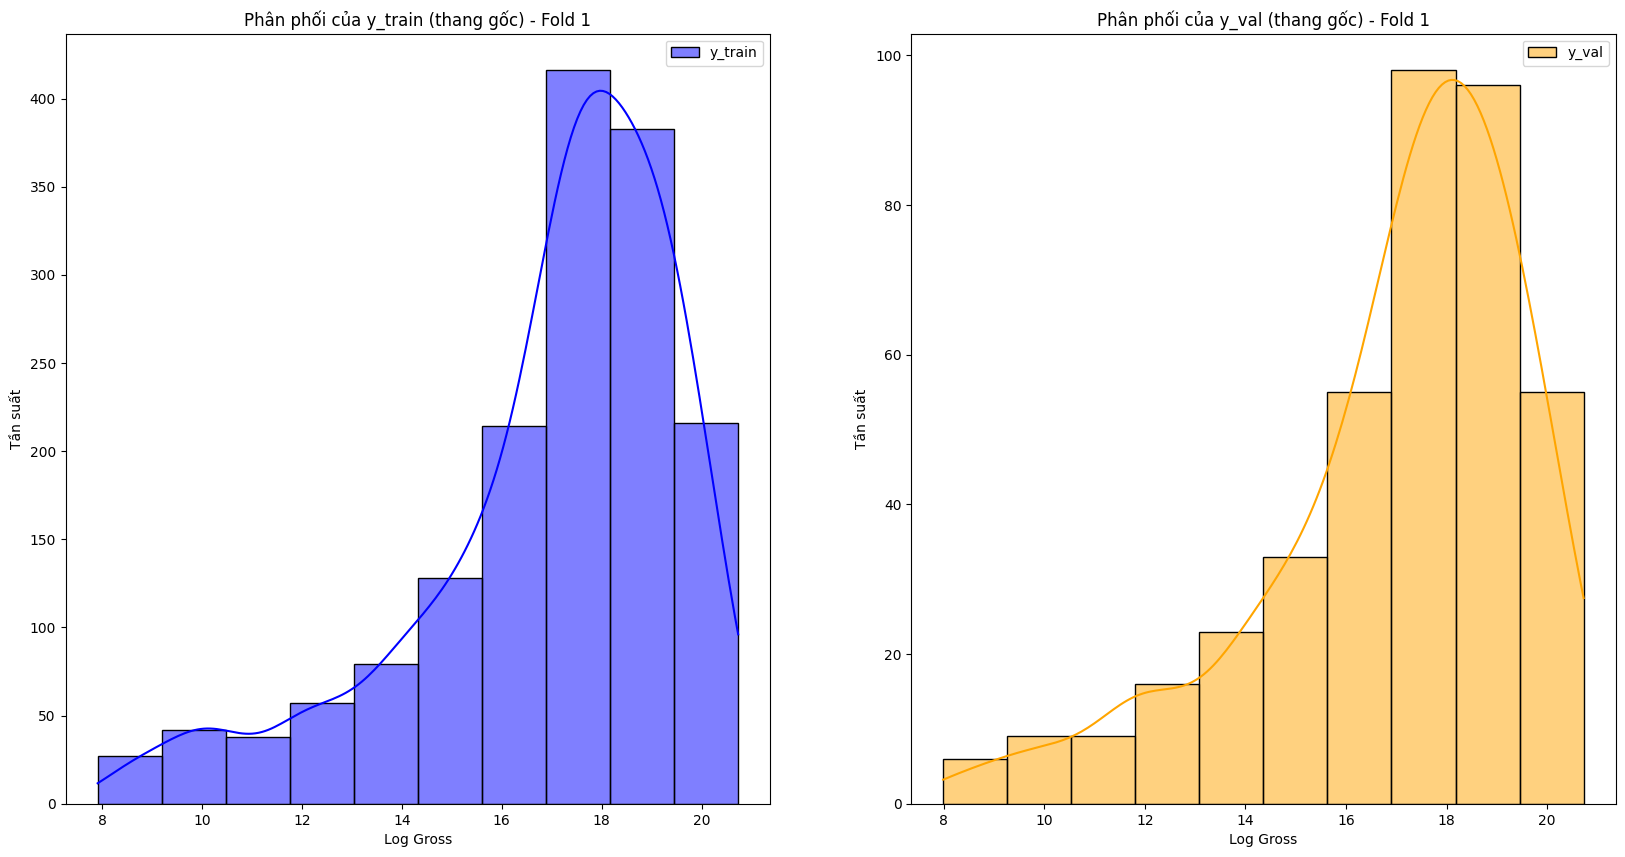

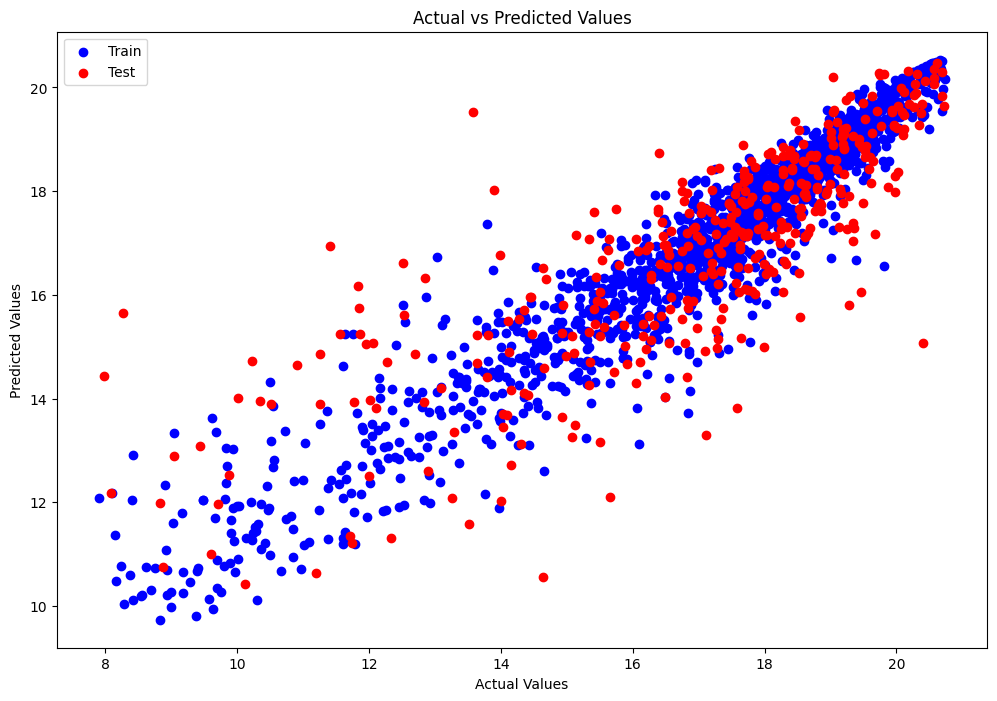

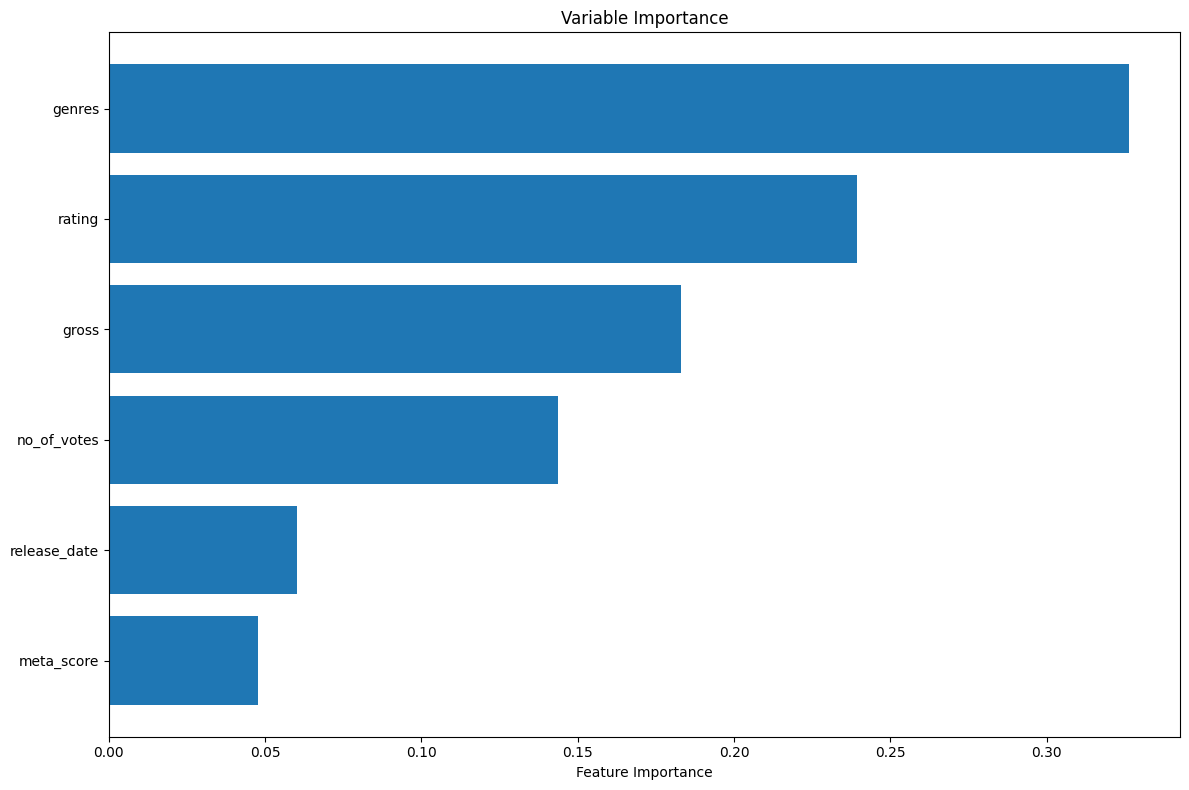


Fold 2
 Best hyperparameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.5237134006091897
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7527
MAE: 46,958,391.5045
MAPE: 3.09%
Test Metrics
R2 score: 0.5832
MAE: 64,628,264.6972
MAPE: 11.11%


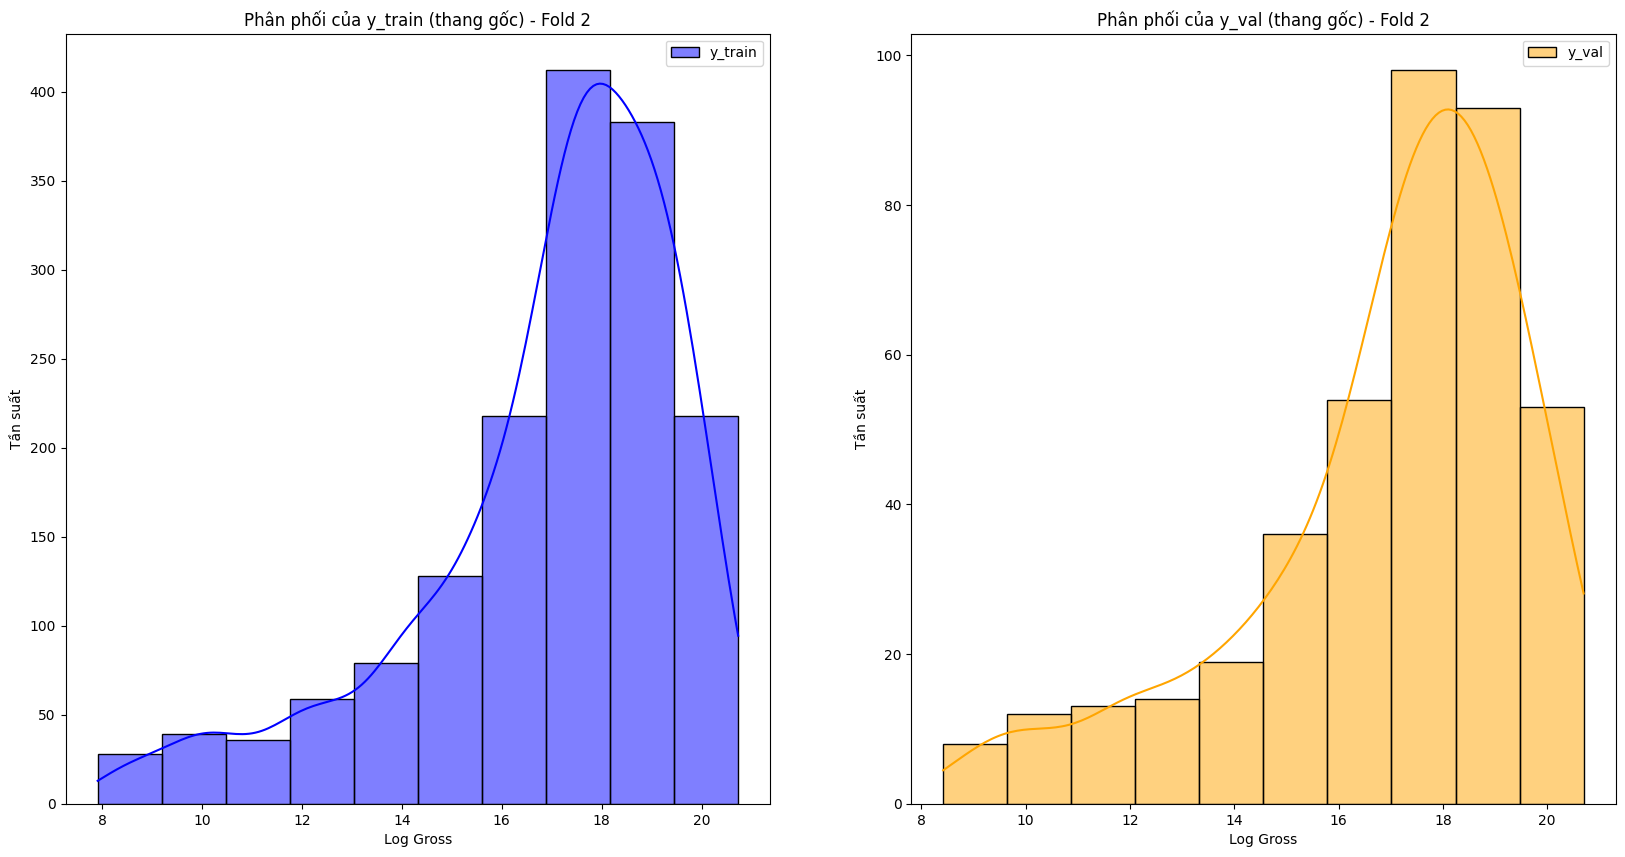

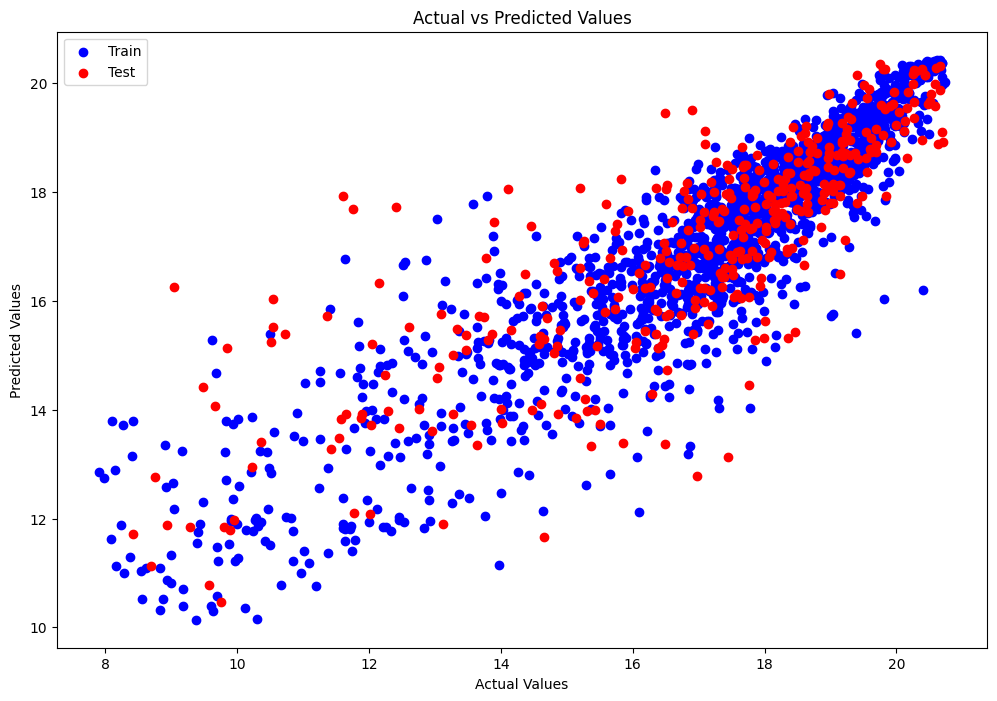

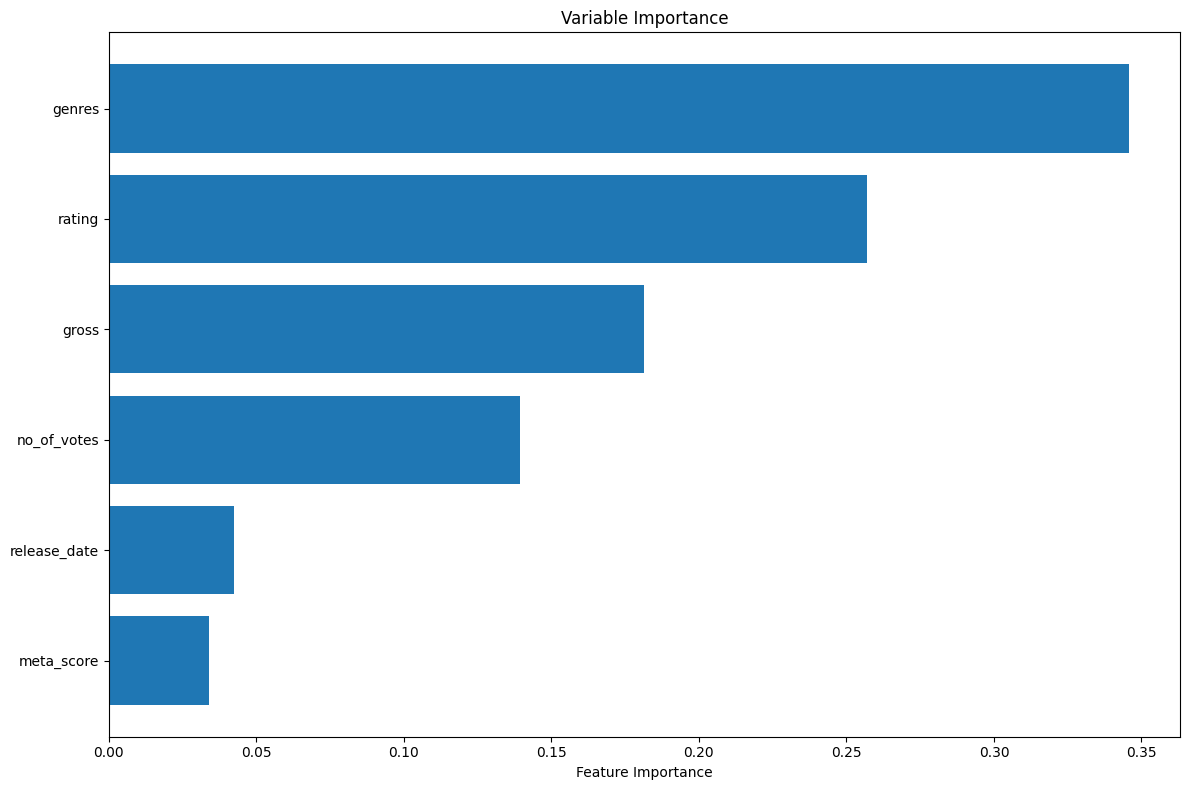


Fold 3
 Best hyperparameters: {'n_estimators': 333, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.360854331495268
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8417
MAE: 34,915,582.1289
MAPE: 1.21%
Test Metrics
R2 score: 0.6925
MAE: 56,747,852.8386
MAPE: 21.20%


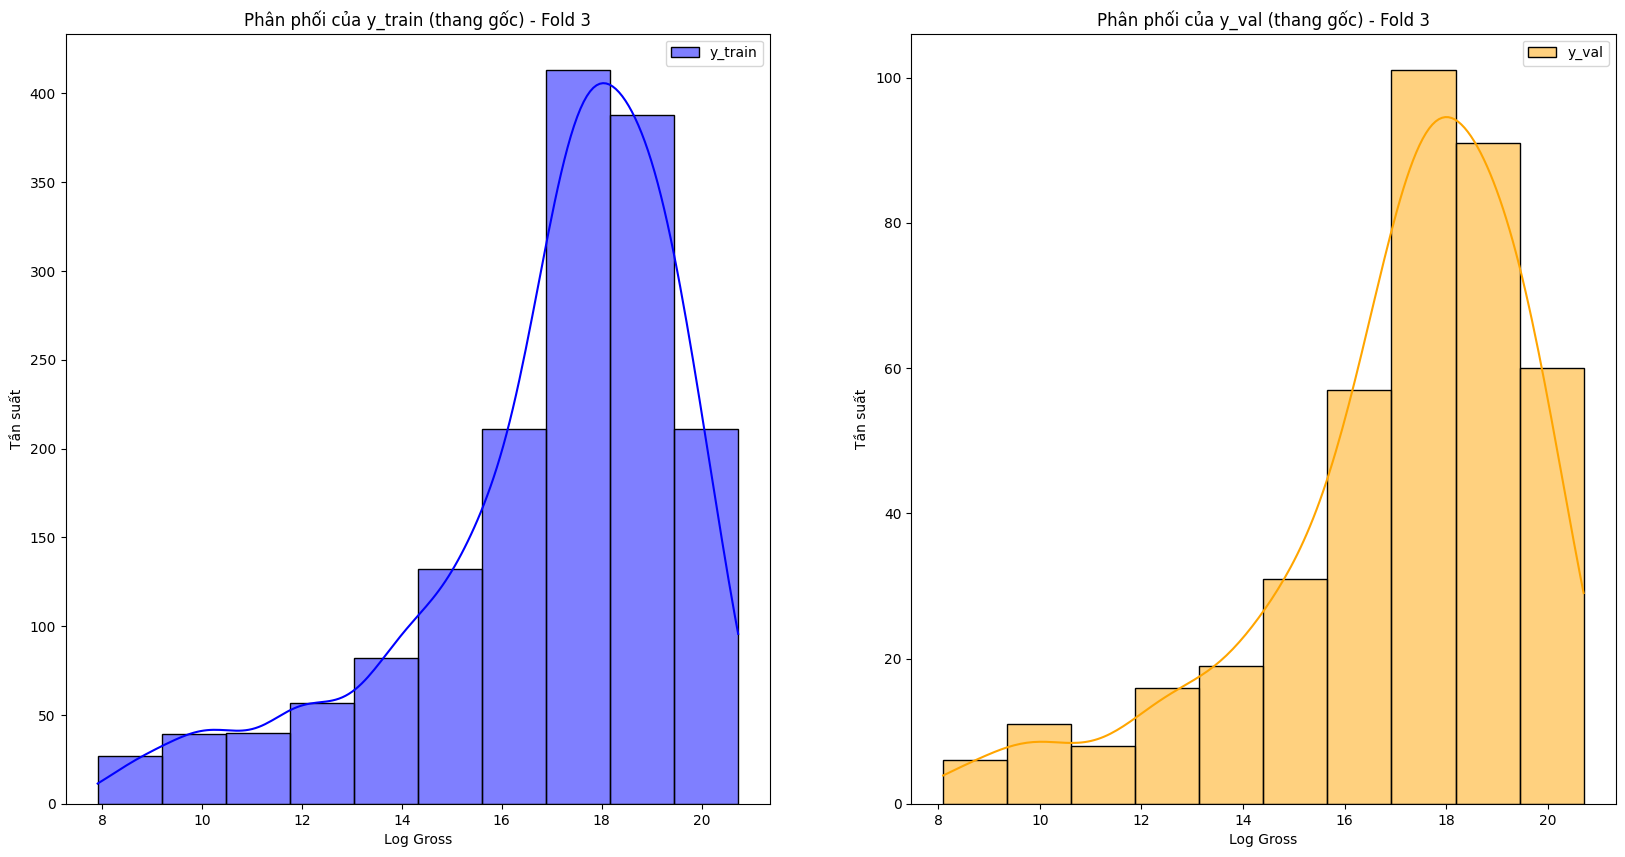

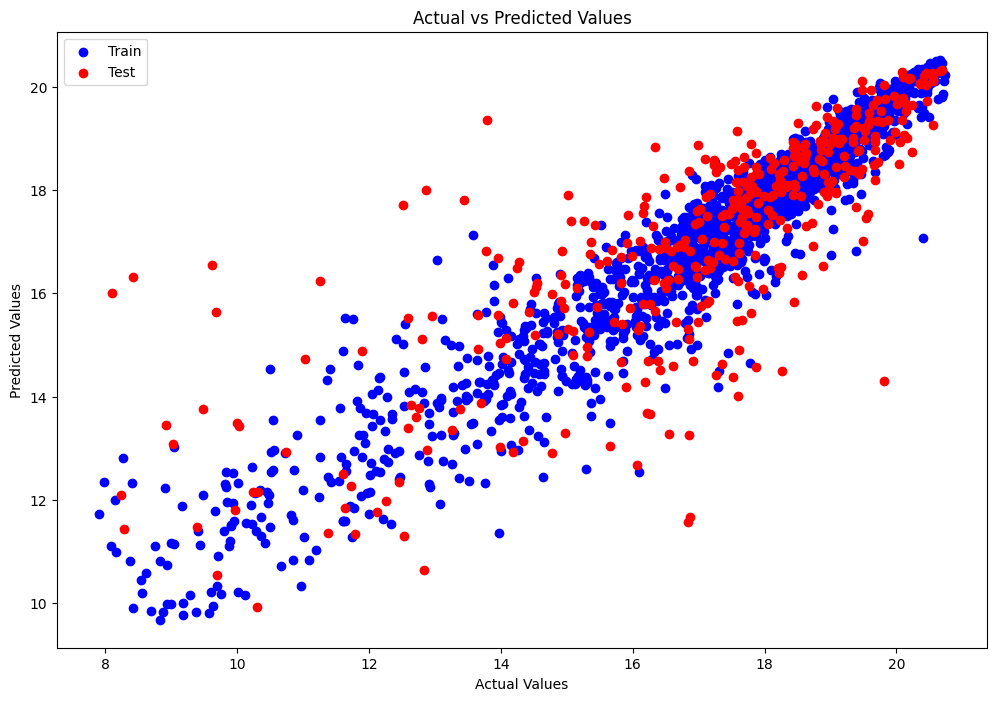

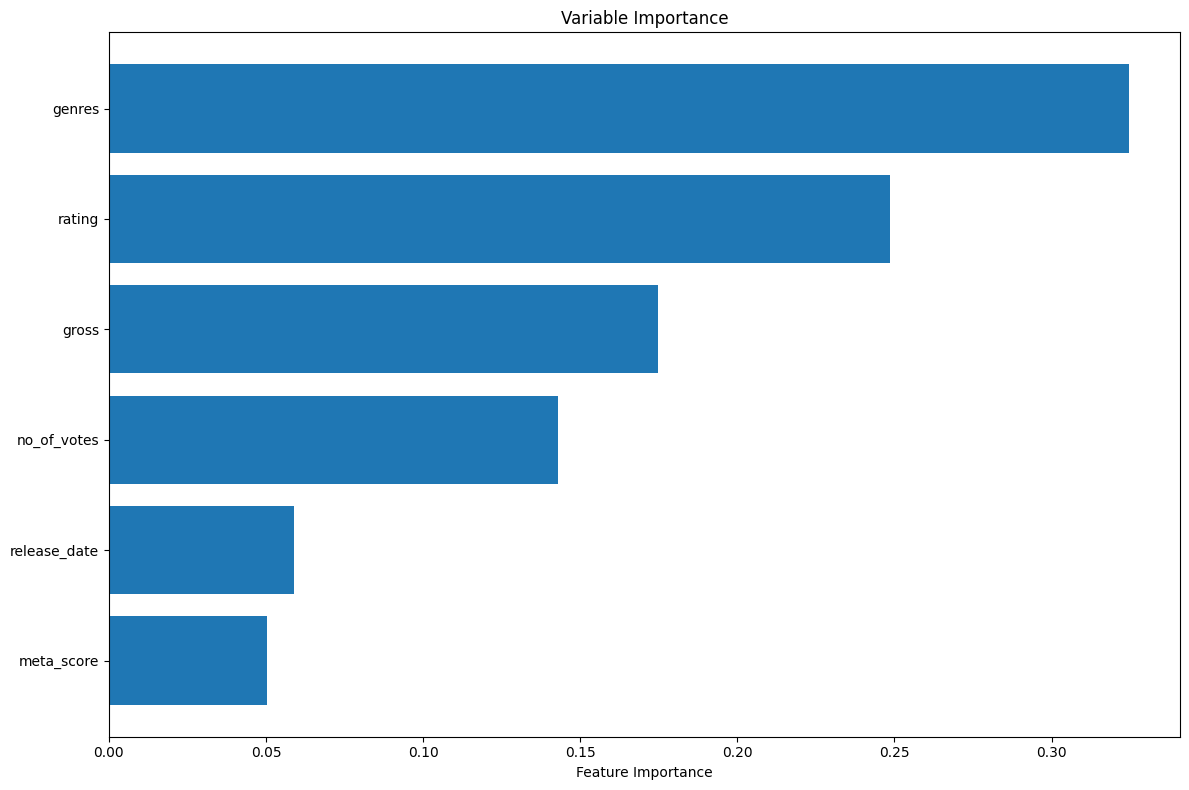


Fold 4
 Best hyperparameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.545511410428418
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7390
MAE: 47,964,890.3720
MAPE: 3.31%
Test Metrics
R2 score: 0.6011
MAE: 59,701,026.2738
MAPE: 11.15%


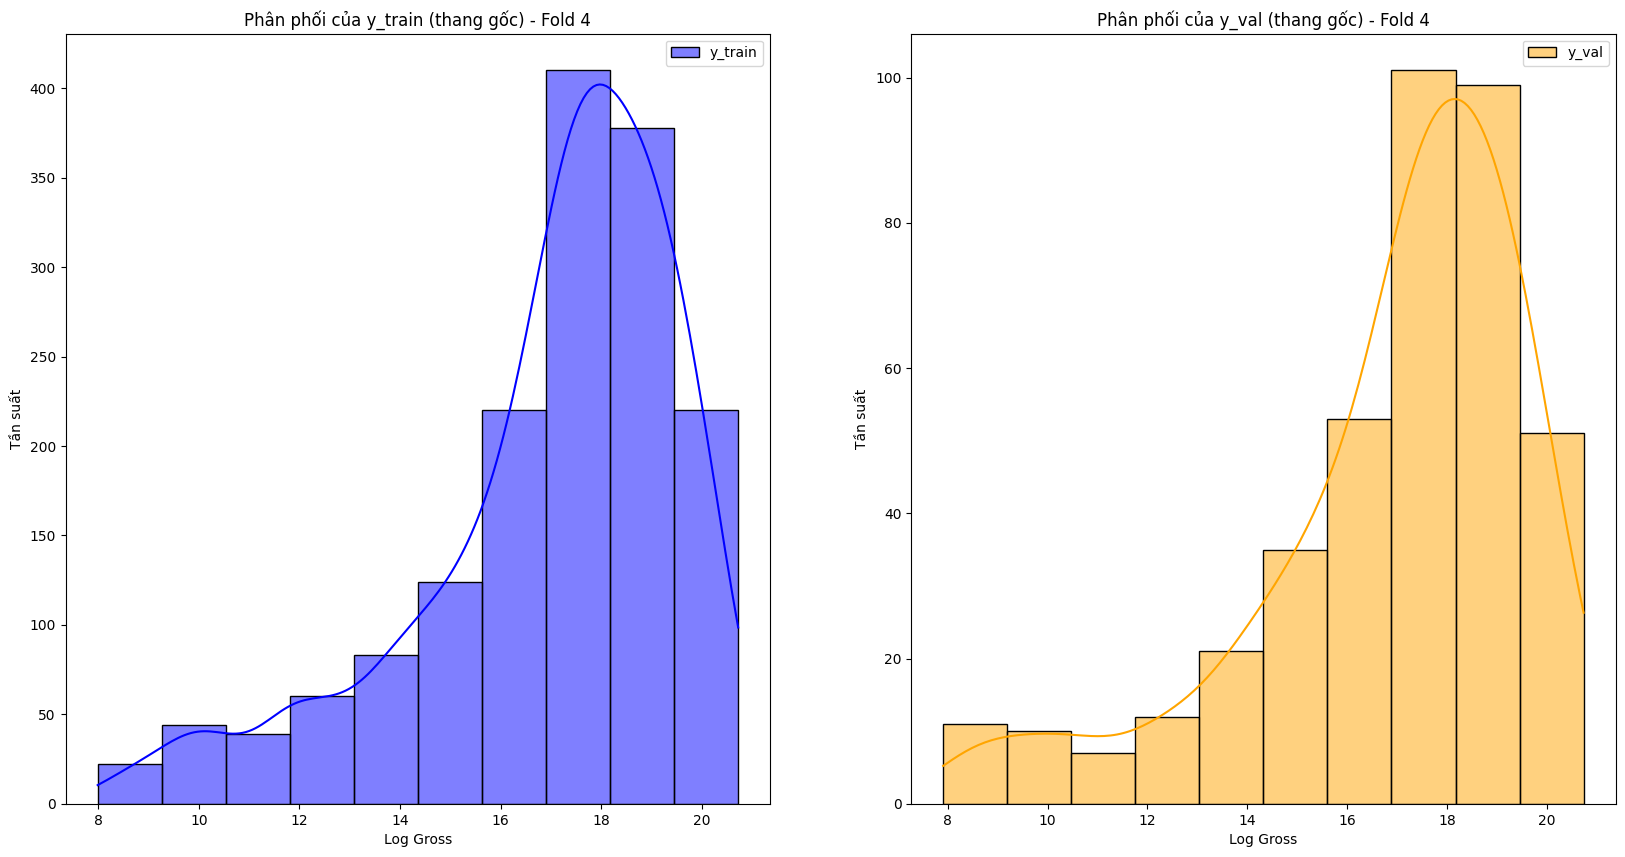

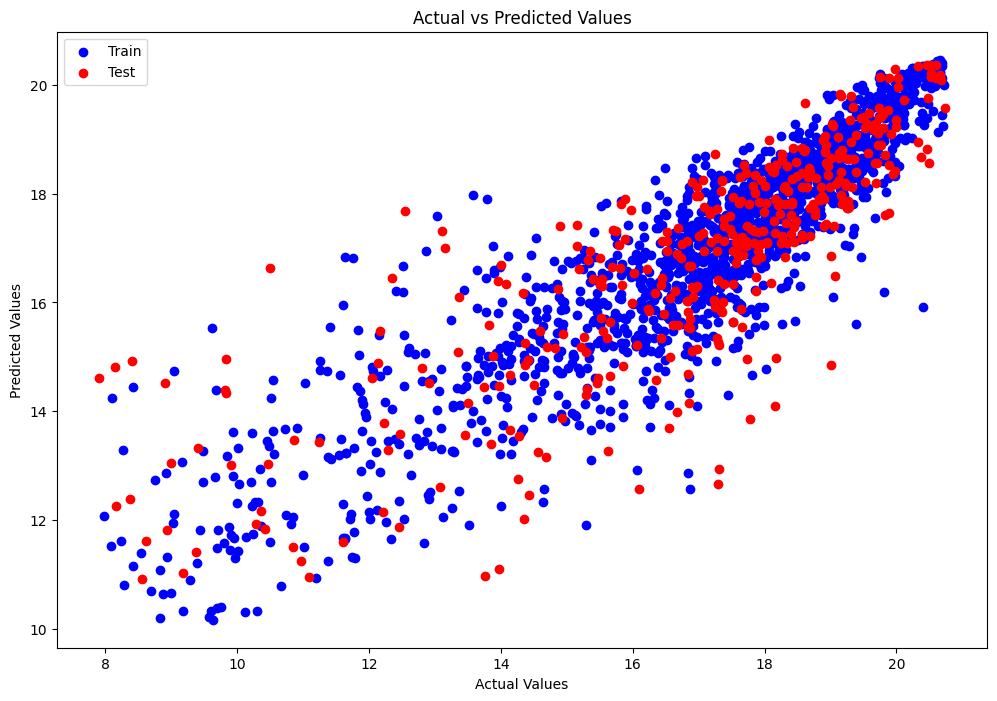

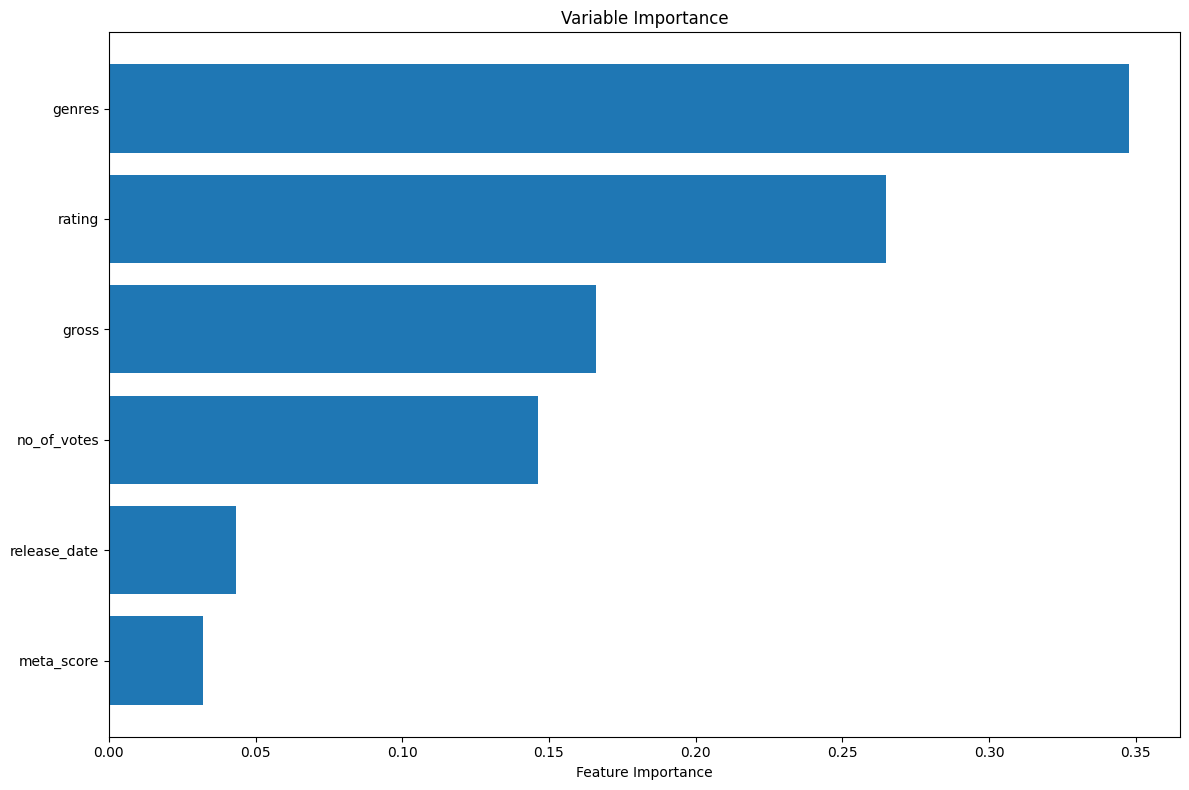


Fold 5
 Best hyperparameters: {'n_estimators': 384, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.6678312704250025
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8423
MAE: 35,440,662.2611
MAPE: 1.47%
Test Metrics
R2 score: 0.6086
MAE: 57,647,693.7211
MAPE: 4.94%


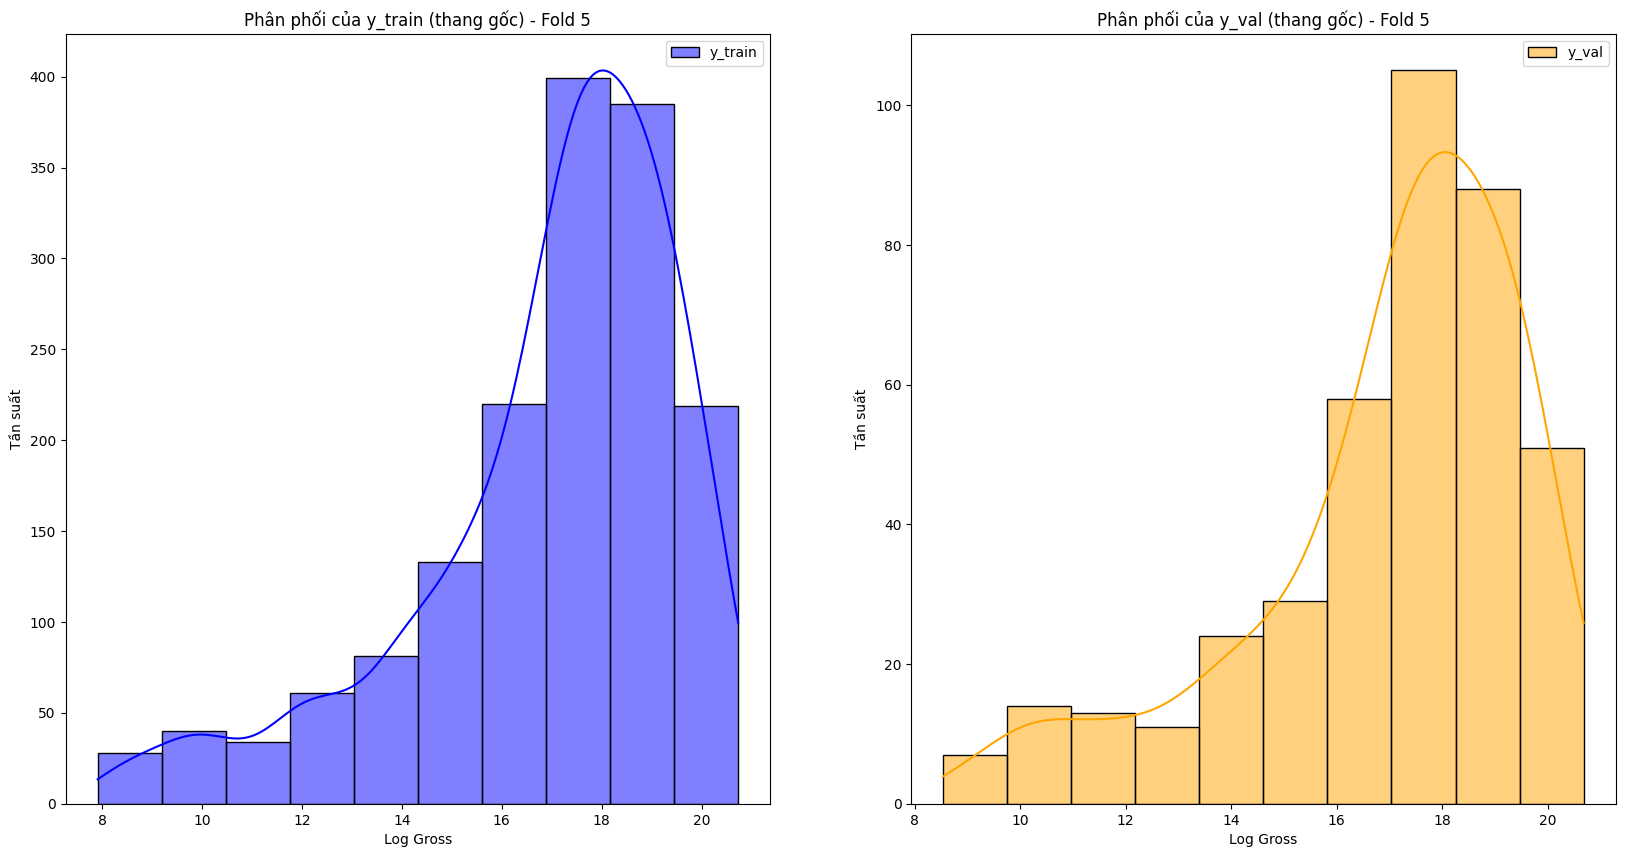

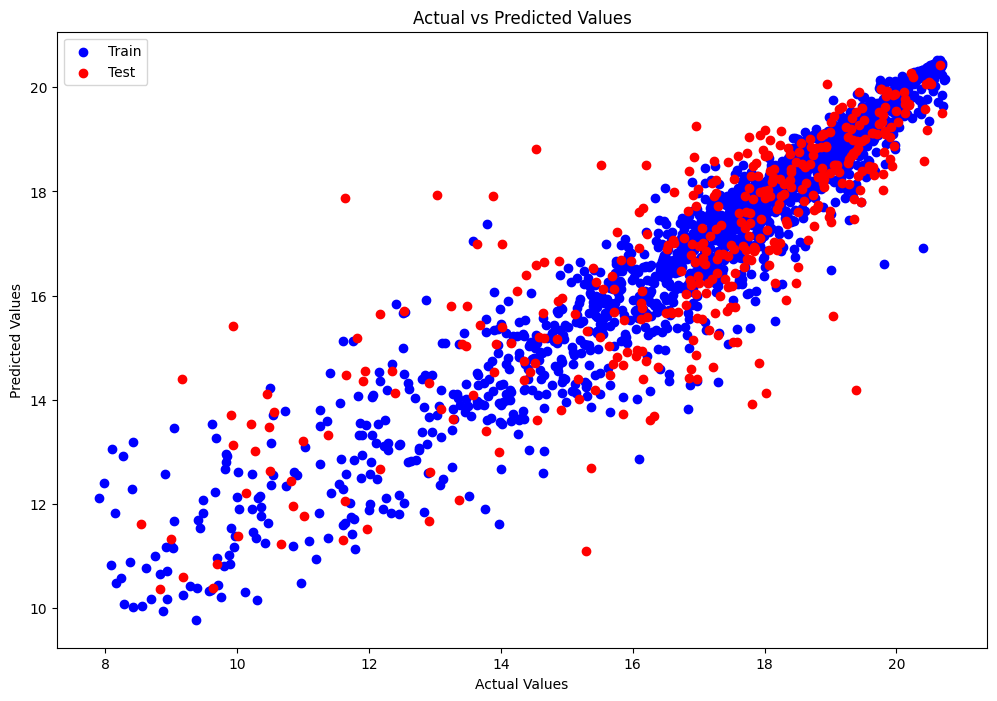

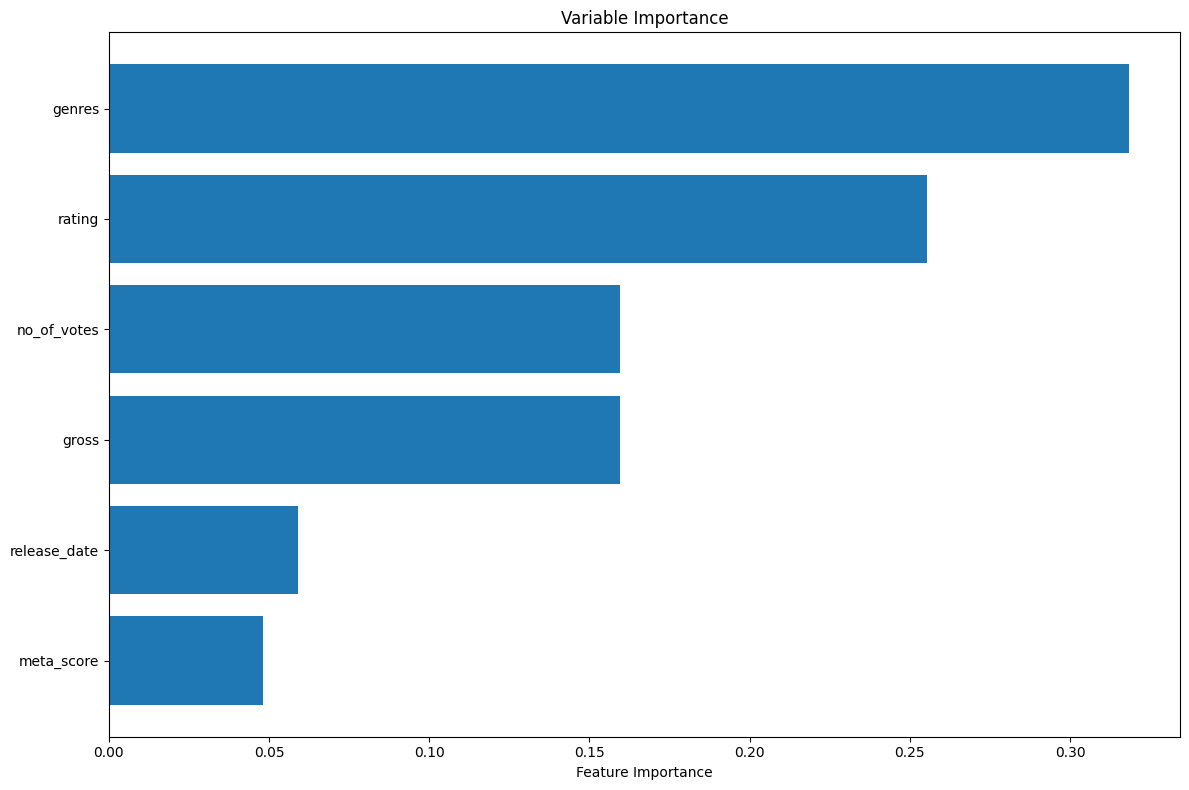

In [4]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from evaluation import visualize_results
import warnings

# warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\nFold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    # Chọn đặc trưng đầu vào và mục tiêu
    #features = ['meta_score', 'rating', 'no_of_votes', 'budget', 'genre_stat_feature', 'country_stat_feature', 'release_date']
    features = ['no_of_votes', 'log_budget',
                'genre_stat_feature','country_stat_feature','rating','release_date']

    target = 'log_gross'

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            'random_state': 42,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
        return -score  # minimize MSE

    #  Tạo study với tên rõ ràng theo từng fold
    study = optuna.create_study(direction="minimize", study_name=f"Fold_{fold+1}_RandomForest")
    study.optimize(objective, n_trials=30)

    print(" Best hyperparameters:", study.best_params)
    print(" Best MSE:", study.best_value)

    best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    #  Vẽ biểu đồ tối ưu và tầm quan trọng tham số
    print(" Hiển thị quá trình tối ưu:")
    plot_optimization_history(study).show()
    plot_param_importances(study).show()

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )
